# Advanced Practice Project: Predictive Maintenance in Industrial Settings

## Introduction

This notebook is part of an advanced practice project for the Master of Data Science program at Teesside University, focusing on predictive maintenance in industrial settings. The goal is to predict machine failures and identify their types using the Machine Predictive Maintenance Classification Dataset from Kaggle.

The project follows a typical machine learning workflow:
1. **Exploratory Data Analysis (EDA)**: Understanding the dataset.
2. **Data Preprocessing**: Preparing the data for modeling.
3. **Modeling**: Building models to predict machine failures and their types.
4. **Evaluation**: Comparing model performance and interpretability.

## Table of Contents

1. [Task and Data Description](#description)
2. [Exploratory Data Analysis](#EDA)
   - 2.1 [ID Columns](#ID)
   - 2.2 [Temperature Conversion](#Temperature)
   - 2.3 [Feature Visualization](#Graphs)
   - 2.4 [Outlier Detection](#outliers)
   - 2.5 [Target Anomalies](#target)
   - 2.6 [Resampling with SMOTE](#resampling)
   - 2.7 [Comparison after resampling](#resample_comparison)
   - 2.8 [Feature Scaling and Encoding](#encoding)
   - 2.9 [PCA and Correlation Heatmap](#pca)
3. [Training Models](#models)
   - 3.1 [Feature Selection](#feature)
   - 3.2 [Label Encoding](#label)
   - 3.3 [Training dataset](#training_dataset)
4. [Model Evaluation](#evaluation)

## 1) **Task and Data description** <a id="description"></a> 

Since real predictive maintenance datasets are generally difficult to obtain and in particular
difficult to publish, the data provided by the Kaggle is a synthetic dataset that reflects
real predictive maintenance encountered in industry to the best of their knowledge.
The dataset consists of 10 000 data points stored as rows with 14 features in columns:
* UID: unique identifier ranging from 1 to 10000;
* Product ID: consisting of a letter L, M, or H for low (60% of all products), medium (30%)
and high (10%) as product quality variants and a variant-specific serial number;
* Air temperature [K]: generated using a random walk process later normalized to a standard
deviation of 2 K around 300 K;
* Process temperature [K]: generated using a random walk process normalized to a standard
deviation of 1 K, added to the air temperature plus 10 K;
* Rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally
distributed noise;
* Torque [Nm]: torque values are normally distributed around 40 Nm with a standard deviation
of 10 Nm and no negative values;
* Tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used
tool in the process;
* Machine failure: label that indicates, whether the machine has failed in this particular data
point for any of the following failure modes are true.
The machine failure consists of five independent failure modes:
* tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear
time between 200 - 240 mins;
* heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference
between air- and process temperature is below 8.6 K and the tools rotational speed is below
1380 rpm;

* power failure (PWF):the product of torque and rotational speed (in rad/s) equals the power
required for the process. If this power is below 3500 W or above 9000 W, the process fails;
* overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for
the L product variant (12,000 M, 13,000 H), the process fails due to overstrain;
* random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process
parameters.
If at least one of the above failure modes is true, the process fails and the ’machine failure’
label is set to 1. It is therefore not transparent to the machine learning method, which of the
failure modes has caused the process to fail.

## 2) **Exploratory Analysis** <a id="EDA"></a>
Our data exploration starts by checking that each entry is unique and there are no duplicates;
this is done by veryfing that the number of unique ProductID corresponds to the number of
observations. Then we print a report to look for missing values and check the data type for each
column.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Default theme
sns.set_theme(palette='tab10',
              font='Lucida Calligraphy',
              font_scale=1.5,
              rc=None)

import matplotlib
matplotlib.rcParams.update({'font.size': 15})
plt.style.use('dark_background')

In [3]:
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

In [4]:
# Import data
df = pd.read_csv('data.csv')
df.sample(6).style.format(precision=2).set_properties(
    **{
        'background-color': '#AA00BB',
        'color': 'white',
        'border-color': 'White'
    }
)

In [5]:
# First checks
print('Features non-null values and data type:')
df.info()
print('Check for duplicate values:')
if df['Product ID'].nunique() != len(df):
    print('There are duplicate values in the data')
else:
    print('No duplicate values found')

Features non-null values and data type:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
Check for duplicate values:
No duplicate values found


### 2.1) ID Columns <a id="ID"></a>
Before going into more technical matters we deal with the two ID columns as the model we will
use could get confused by them, since it is unrealistic to think that the failure of a machine
depends on its identifier. However, while UDI results in being a copy of the dataframe index,
the column Product ID is made up of an initial letter followed by five numbers; there is a small
chance that an hidden pattern lies behind this structure. However, the initial letter corresponds
to the machine Type and the number sequences define three intervals based on the same feature;
this allows to confirm that the Product ID column does not actually carry any more information
than the feature Type and it is legit to drop it.
The following histogram shows the number sequences:

In [6]:
df = df.drop(["UDI","Product ID"],axis=1)
df.sample(6).style.format(precision=2).set_properties(
    **{
        'background-color': '#AA00BB',
        'color': 'white',
        'border-color': 'White'
    }
)

### 2.2) Temperature Conversion and Calculation of Temperature Difference <a id="Temperature"></a>
In this section, we convert temperatures from **Kelvin (K) to Celsius (°C)** using the formula:  

\[
°C = K - 273.15
\]

After conversion, we rename the columns accordingly and compute the **temperature difference** between the air temperature and process temperature.  

Finally, we display a sample of the dataset with a customized table style for better visualization.


In [7]:
## Converting temperature in centigrate from Kelvin [1 K = -272.15 °C  ] 

df["Air temperature [K]"] = df["Air temperature [K]"] - 272.15
df["Process temperature [K]"] = df["Process temperature [K]"] - 272.15


In [8]:
df["Temperature difference [K]"] = df["Process temperature [K]"] - df["Air temperature [K]"]
df.sample(6).style.format(precision=2).set_properties(
    **{
        'background-color': '#AA00BB',
        'color': 'white',
        'border-color': 'White'
    }
)

In [9]:
# Rename features
df.rename(mapper={'Air temperature [K]': 'Air temperature',
                    'Process temperature [K]': 'Process temperature',
                    'Rotational speed [rpm]': 'Rotational speed',
                    'Torque [Nm]': 'Torque',
                    'Tool wear [min]': 'Tool wear',
                    'Temperature difference [K]':'Temperature difference'}, axis=1, inplace=True)
df['Tool wear'] = df['Tool wear'].astype('float64')
df['Rotational speed'] = df['Rotational speed'].astype('float64')

### 2.3) Graphical Representation of Features <a id="Graphs"></a>

To gain deeper insights into the data, we will now visualize the distribution and relationships between key features.  

We will use **histograms, box plots, and scatter plots** to analyze the data trends, detect potential outliers, and understand feature distributions.  

These visualizations will help us better interpret the dataset and identify patterns that may influence our analysis.


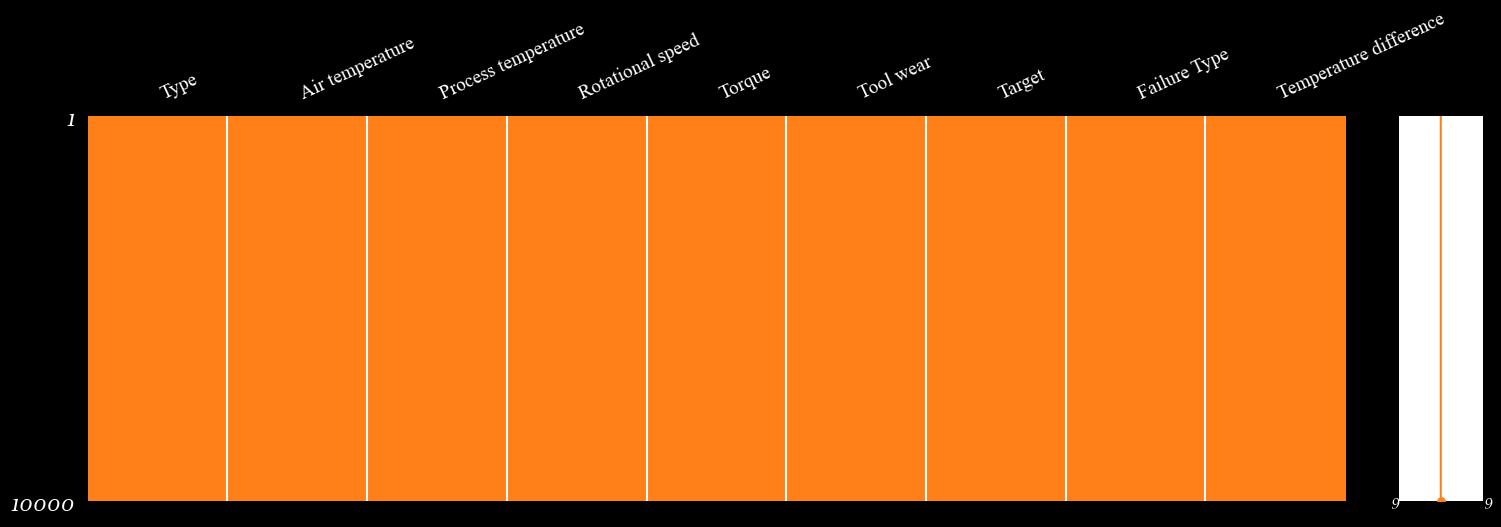

In [10]:
import missingno as msno
msno.matrix(df, figsize=(18,5), fontsize=12, color=(1, 0.5, 0.1));
plt.xticks(rotation=25,fontname='Times New Roman', fontsize=14);

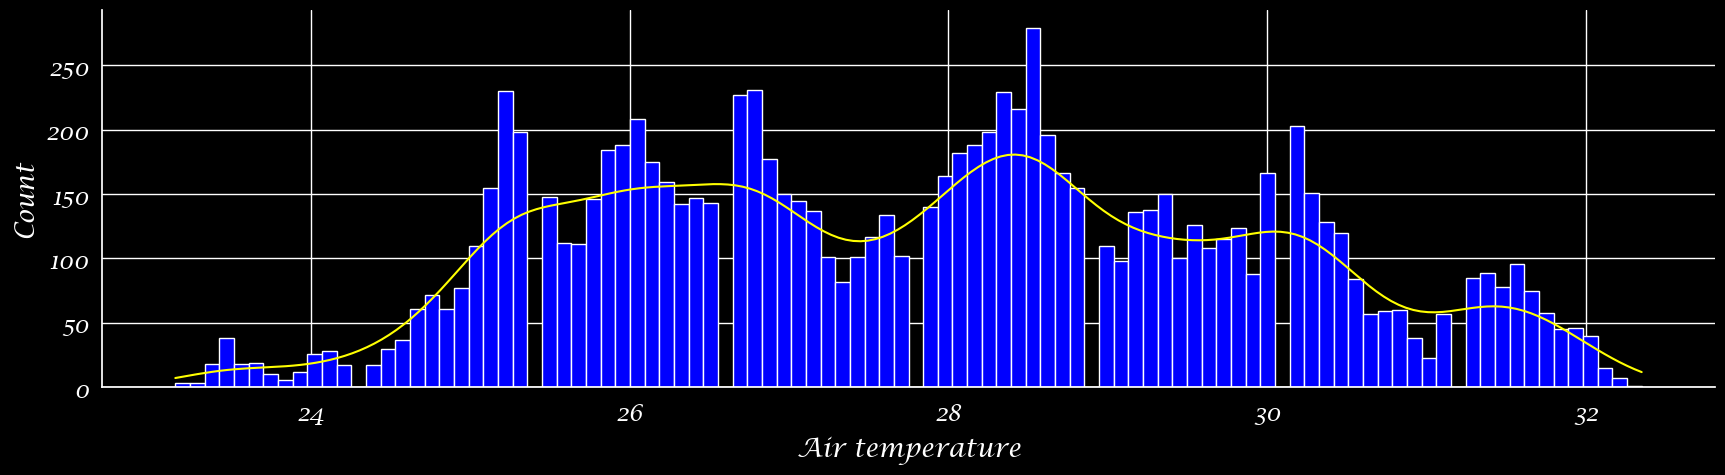

In [11]:
sns.displot(data=df, x="Air temperature", kde=True, bins = 100,color = "yellow", facecolor = "blue",height = 5, aspect = 3.5);

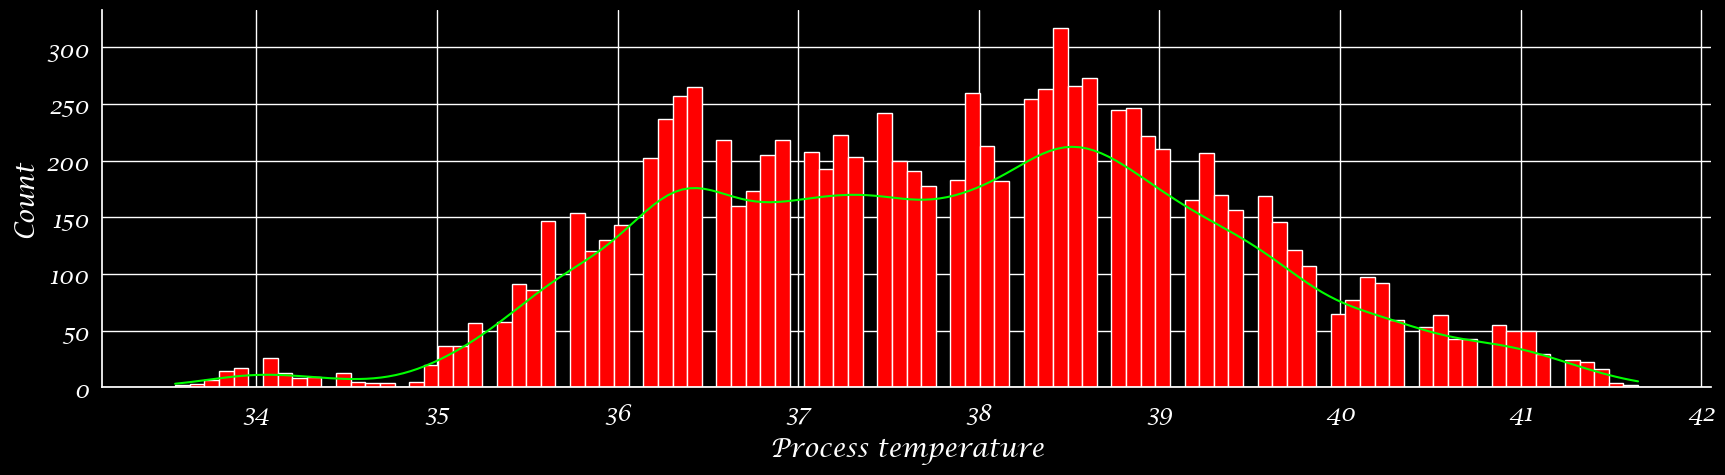

In [12]:
sns.displot(data=df, x="Process temperature", kde=True, bins = 100,color = "lime", facecolor = "red",height = 5, aspect = 3.5);

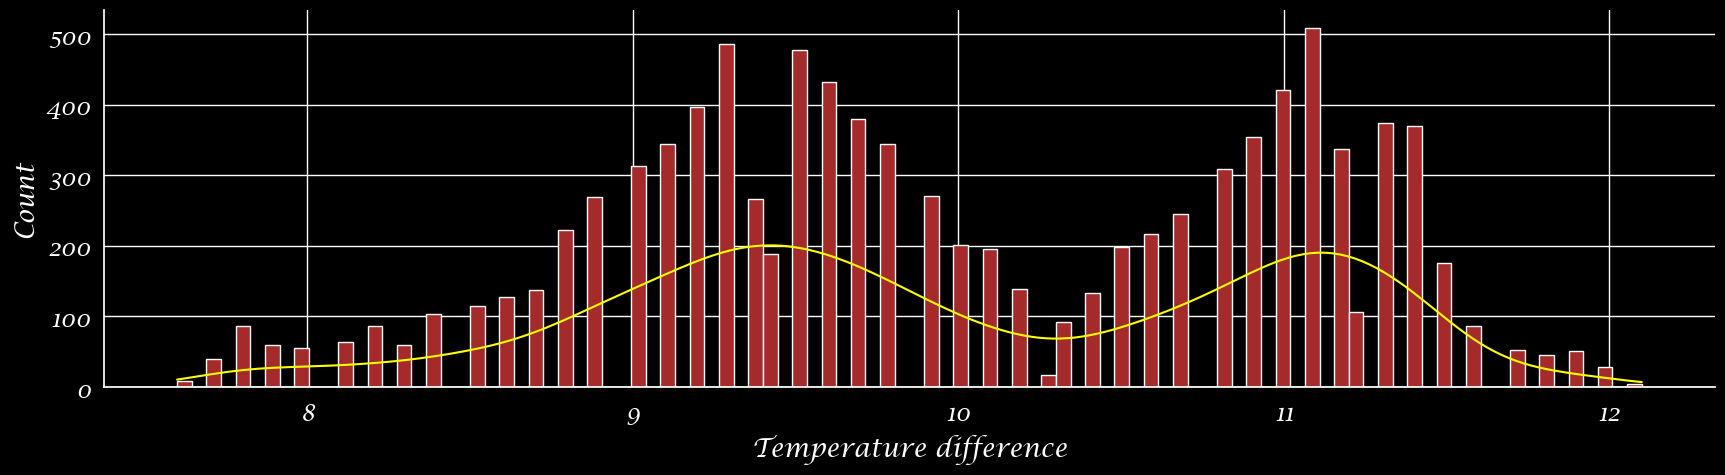

In [13]:
sns.displot(data=df, x="Temperature difference", kde=True, bins = 100,color = "yellow", facecolor = "brown",height = 5, aspect = 3.5);

In [14]:
for col in df[['Type','Target','Failure Type']]:
    print(df[col].value_counts()) 
    print("****"*8)

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64
********************************
Target
0    9661
1     339
Name: count, dtype: int64
********************************
Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64
********************************


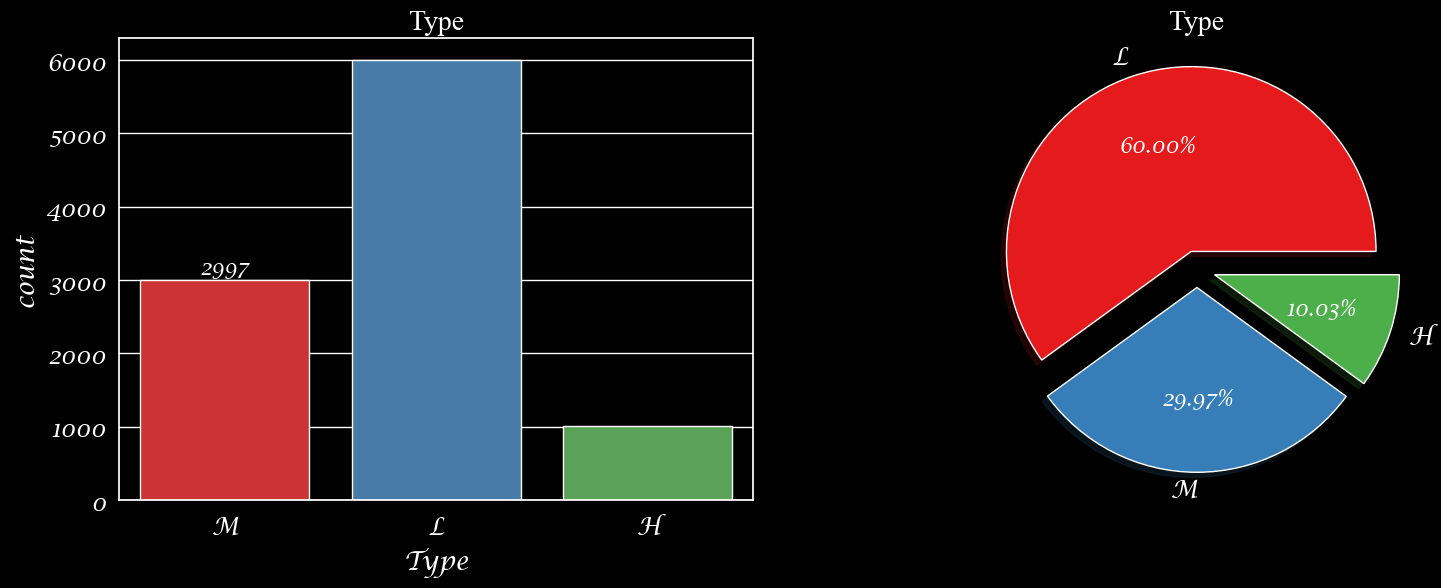

In [15]:
palette = sns.color_palette("Set1")  # You can change this to any Seaborn palette

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar plot
ax1 = sns.countplot(x='Type', data=df, ax=axes[0], palette=palette)
ax1.bar_label(ax1.containers[0])
axes[0].set_title("Type", fontsize=20, color='White', fontname='Times New Roman')

# Pie chart with matching colors
type_counts = df['Type'].value_counts()
axes[1].pie(type_counts, labels=type_counts.index, autopct='%1.2f%%', explode=[0.1] * len(type_counts),
            shadow=True, colors=palette)

axes[1].set_title("Type", fontsize=20, color='White', fontname='Times New Roman')

plt.show()

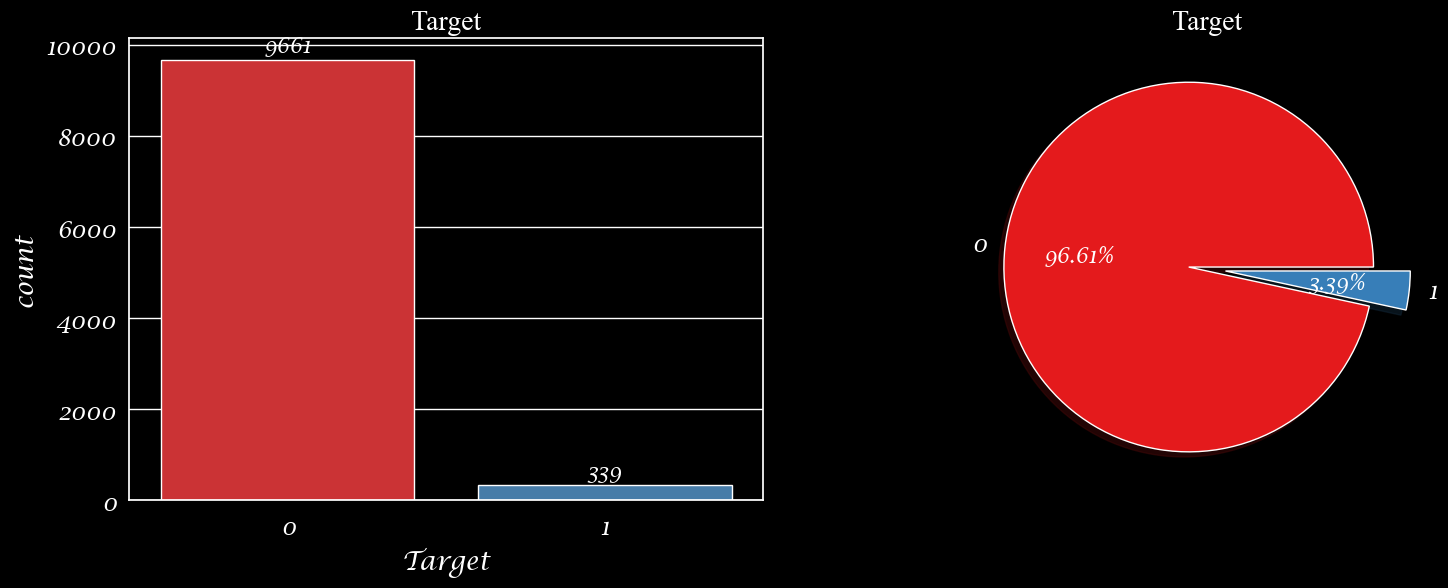

In [16]:
palette = sns.color_palette("Set1")  

# Bar plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
ax1 = sns.countplot(x='Target', data=df, ax=axes[0], palette=palette)

# Ensure all bars are labeled, even small values
for container in ax1.containers:
    ax1.bar_label(container, fmt='%d', label_type='edge', fontsize=15, color='white', padding=0)

axes[0].set_title("Target", fontsize=20, color='White', fontname='Times New Roman')

# Pie chart with matching colors
type_counts = df['Target'].value_counts()
axes[1].pie(type_counts, labels=type_counts.index, autopct='%1.2f%%', explode=[0.1] * len(type_counts),
            shadow=True, colors=palette)

axes[1].set_title("Target", fontsize=20, color='White', fontname='Times New Roman')

plt.show()

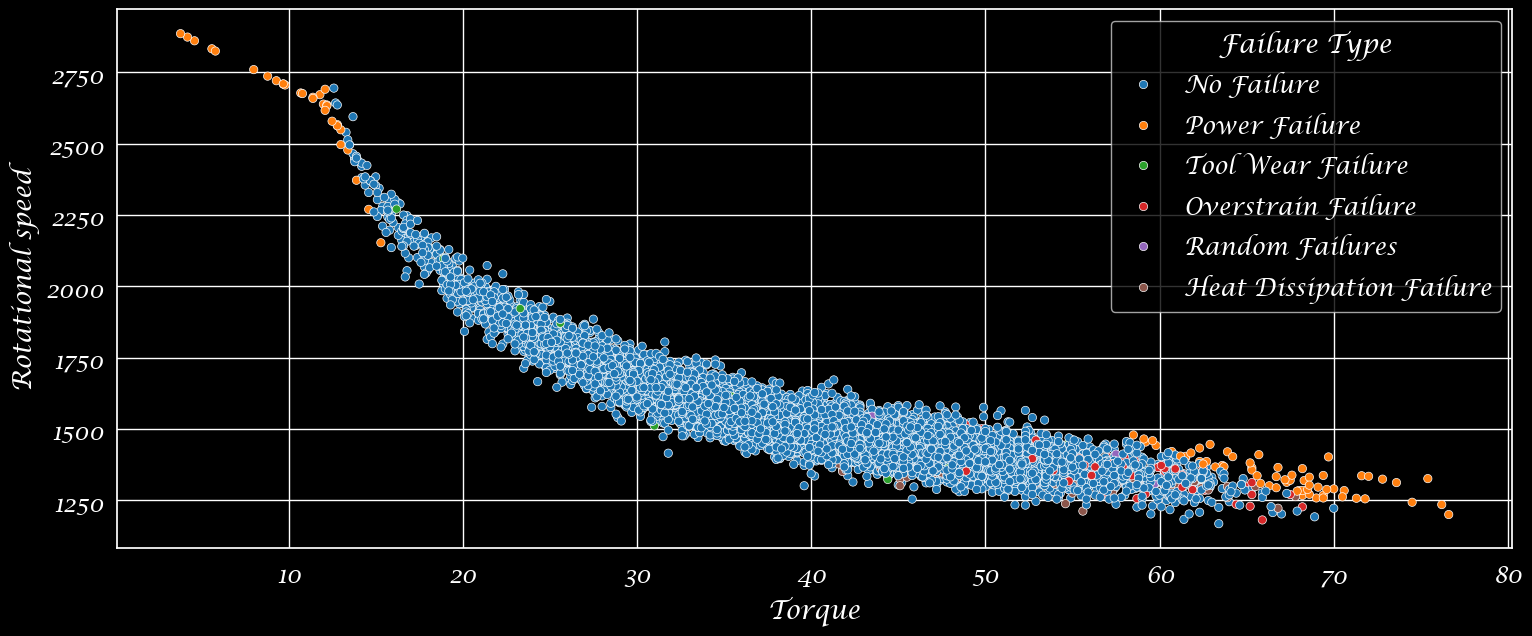

In [17]:
plt.figure(figsize=(18,7))
sns.scatterplot(data=df, x="Torque", y="Rotational speed", hue="Failure Type",palette="tab10");

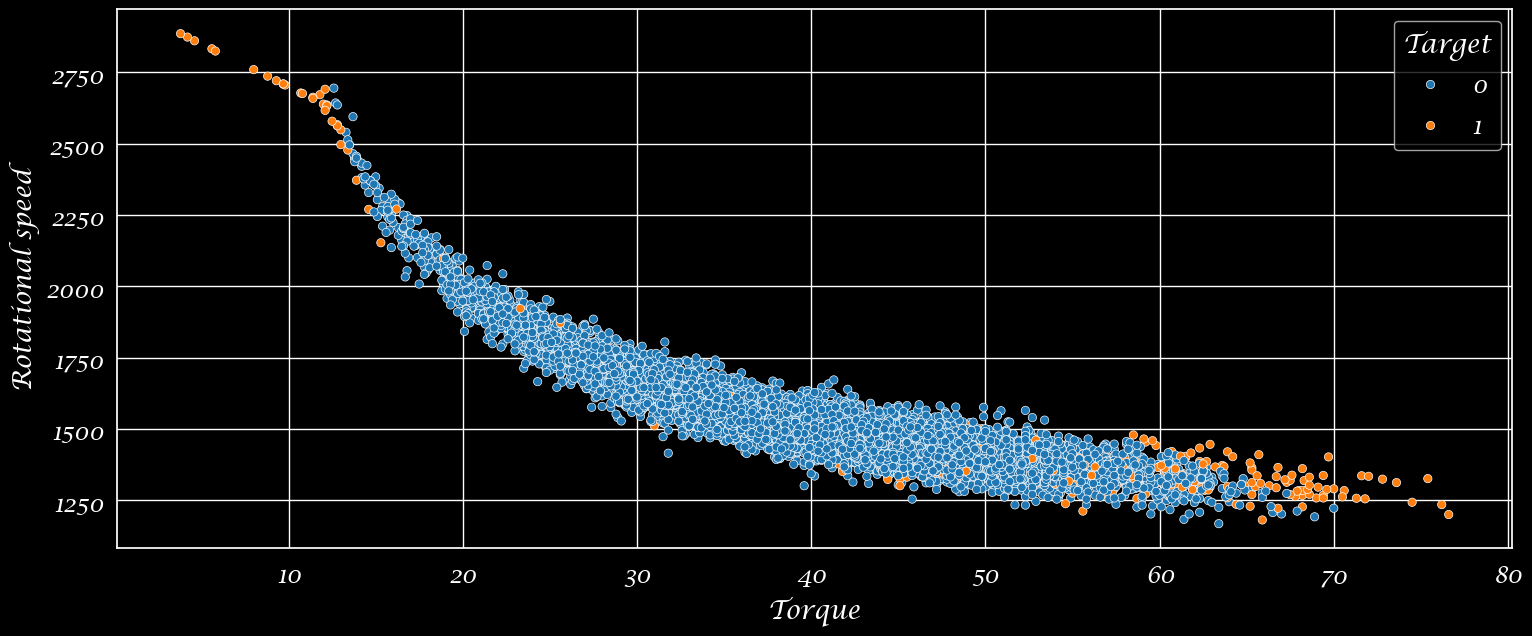

In [18]:
plt.figure(figsize=(18,7))
sns.scatterplot(data=df, x="Torque", y="Rotational speed", hue="Target",palette="tab10");

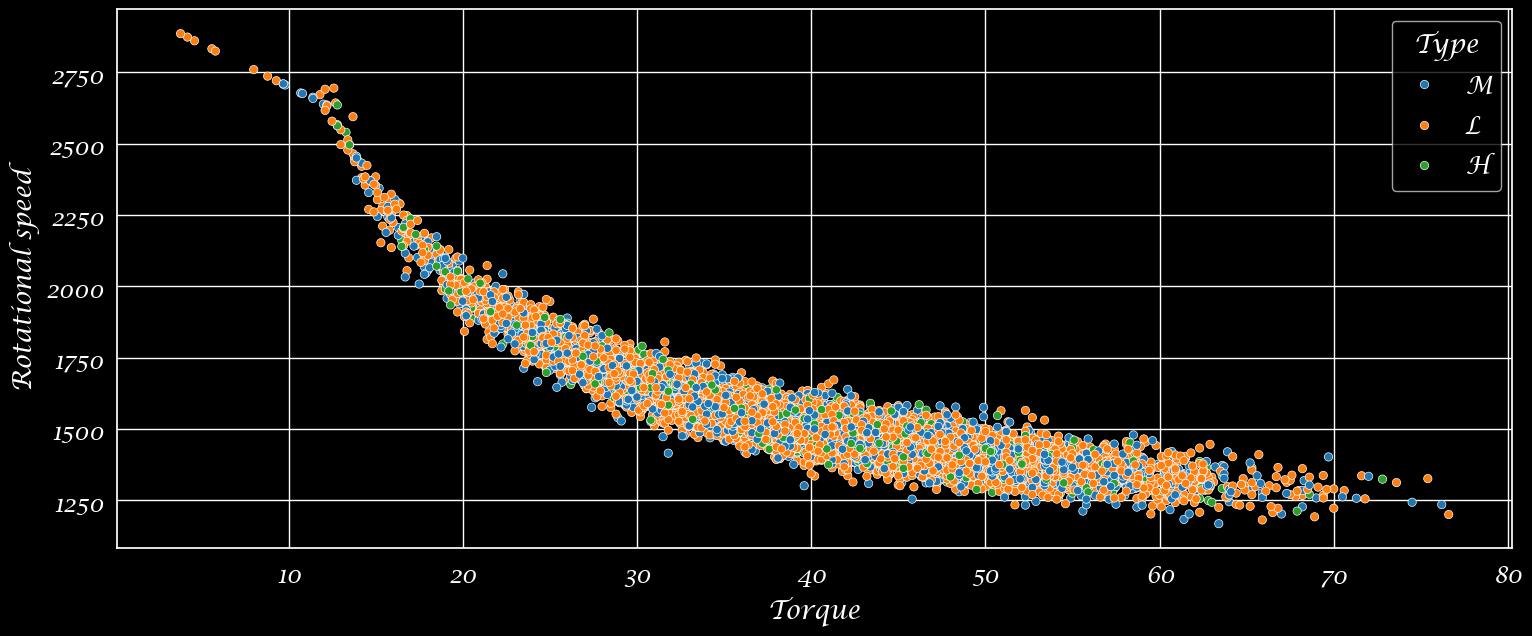

In [19]:
plt.figure(figsize=(18,7))
sns.scatterplot(data=df, x="Torque", y="Rotational speed", hue="Type",palette="tab10");

### 2.4) Outliers inspection <a id="outliers"></a>

The goal of this section is to check if the dataset contains any outlier, which are usually misleading
for machine learning algorithms. We begin by looking at a statistical report of the numerical
features.

In [20]:
df.describe().style.background_gradient(cmap="magma")

We can guess the presence of outliers in Rotational Speed and Torque because the maximum is
very different from the third quartile. To make this consideration more concrete we take a closer
look at the situation with boxplots, using histograms to understand the distribution.

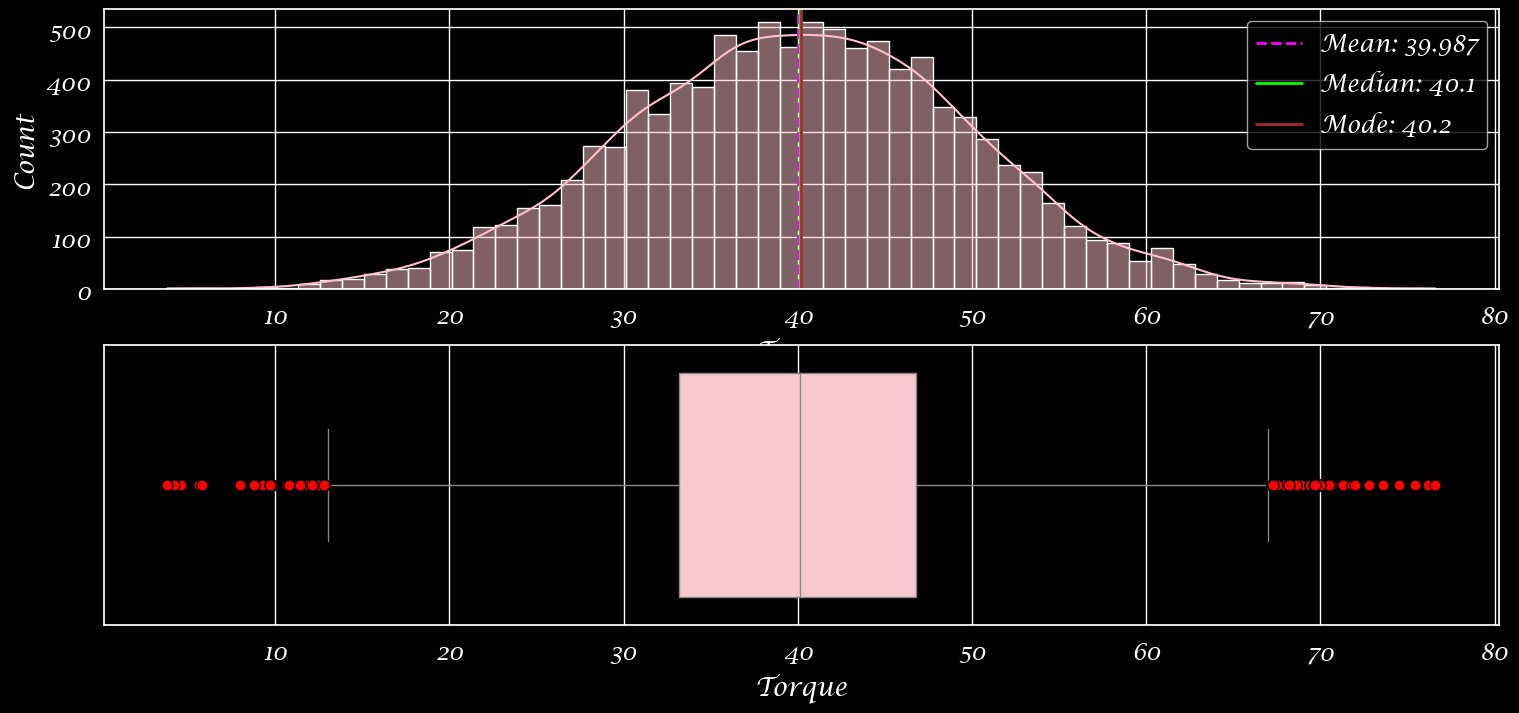

In [21]:
import statistics

def plot_hist(feature):
    fig, ax = plt.subplots(2, 1, figsize=(18, 8))
    
    sns.histplot(data = df[feature], kde = True, ax = ax[0],color='pink')

    ax[0].axvline(x = df[feature].mean(), color = 'Magenta', linestyle = '--', linewidth = 2, label = 'Mean: {}'.format(round(df[feature].mean(), 3)))
    ax[0].axvline(x = df[feature].median(), color = 'lime', linewidth = 2, label = 'Median: {}'.format(round(df[feature].median(), 3)))
    ax[0].axvline(x = statistics.mode(df[feature]), color = 'brown', linewidth = 2, label = 'Mode: {}'.format(statistics.mode(df[feature])))
    ax[0].legend()
    
    sns.boxplot(x=df[feature], ax=ax[1], color='pink', flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markeredgecolor': 'black', 'markersize': 8})
    
    plt.show()

plot_hist('Torque')

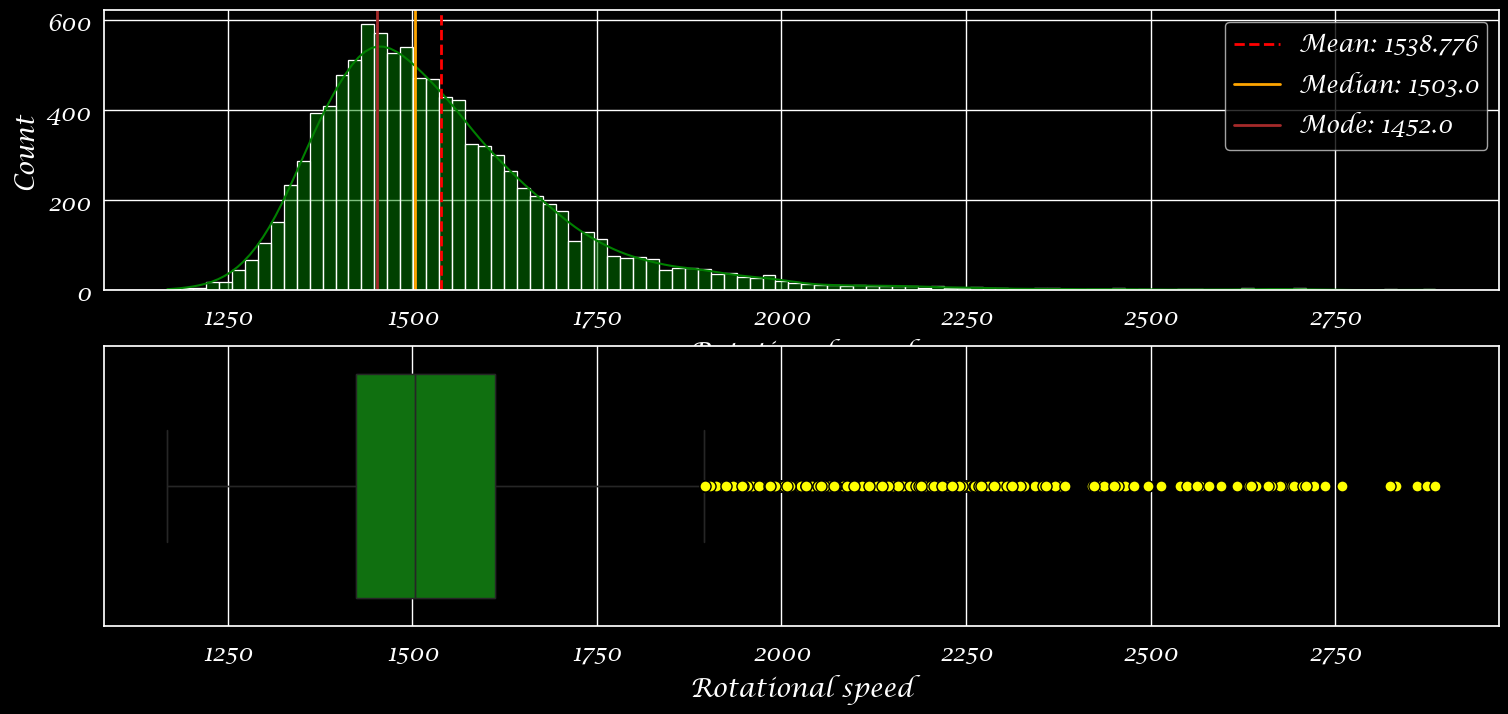

In [22]:
def plot_hist(feature):
    fig, ax = plt.subplots(2, 1, figsize=(18, 8))
    
    sns.histplot(data = df[feature], kde = True, ax = ax[0],color='green')

    ax[0].axvline(x = df[feature].mean(), color = 'red', linestyle = '--', linewidth = 2, label = 'Mean: {}'.format(round(df[feature].mean(), 3)))
    ax[0].axvline(x = df[feature].median(), color = 'orange', linewidth = 2, label = 'Median: {}'.format(round(df[feature].median(), 3)))
    ax[0].axvline(x = statistics.mode(df[feature]), color = 'brown', linewidth = 2, label = 'Mode: {}'.format(statistics.mode(df[feature])))
    ax[0].legend()
    
    sns.boxplot(x = df[feature], ax = ax[1],color='green')
    sns.boxplot(x=df[feature], ax=ax[1], color='green', flierprops={'marker': 'o', 'markerfacecolor': 'yellow', 'markeredgecolor': 'black', 'markersize': 8})
    
    plt.show()

plot_hist('Rotational speed')

The boxplots highlight possible outliers in the features mentioned above, however in the case
of Torque these are probably traceable to the way outliers are detected using boxplots (since the
distribution is Gaussian it would be more appropriate to use the 3σ rule instead of the IQR); in
the case of Rotational Speed the Gaussian distribution is skewed and it is not unrealistic to think
that the few observation with high Rotational Speed are going to fail. As a result we keep the
outliers for now and we reserve the right to decide whether to act on them or not after considering
other aspects.

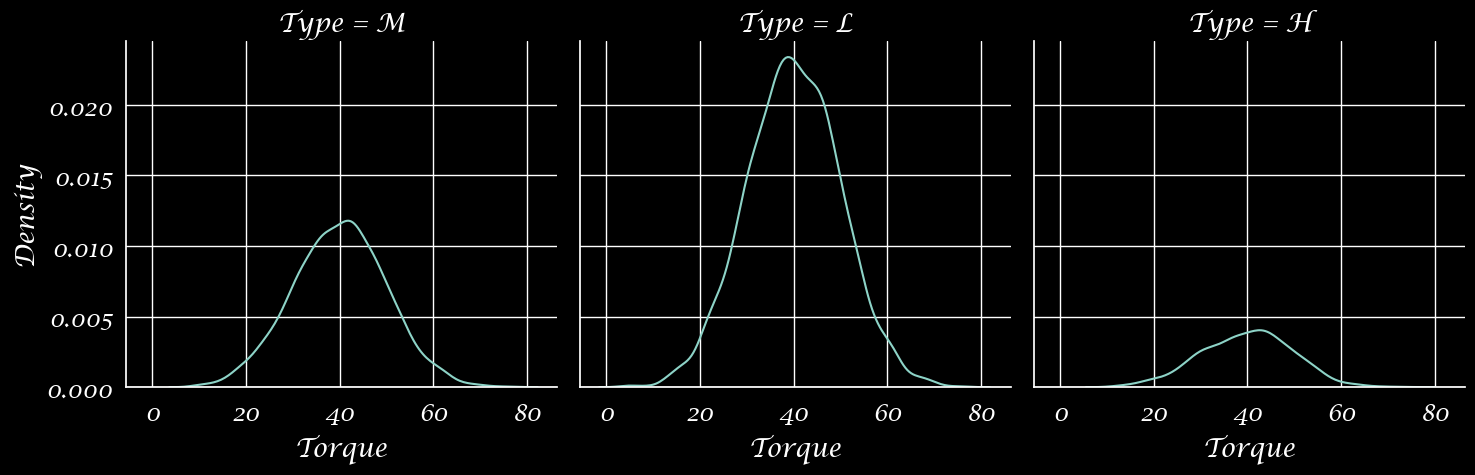

In [23]:
sns.displot(data=df, x="Torque", col="Type", kind="kde");

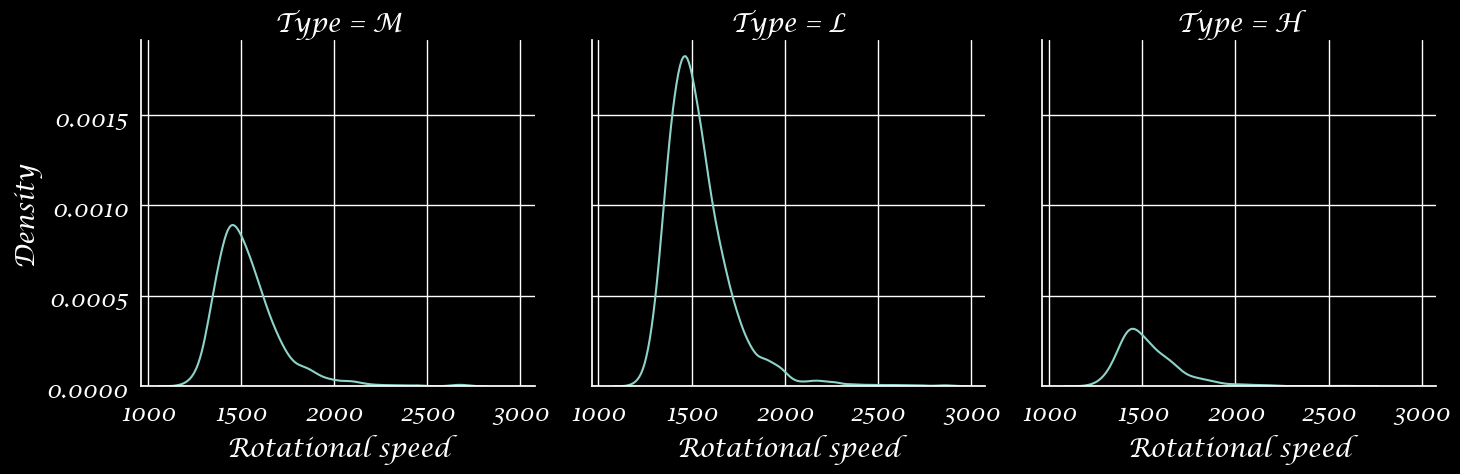

In [24]:
sns.displot(data=df, x="Rotational speed", col="Type", kind="kde");

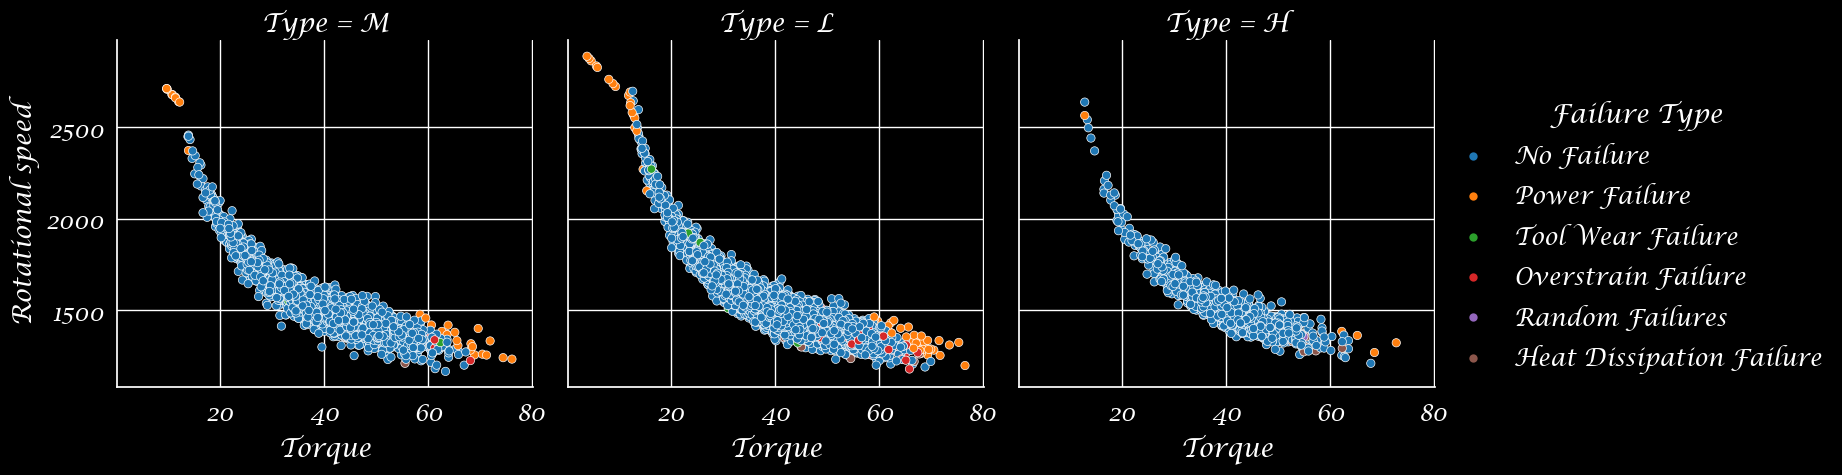

In [25]:
sns.relplot(data=df, x="Torque", y="Rotational speed", hue="Failure Type",col="Type",palette='tab10');

### 2.5) Target anomalies <a id="target"></a>

In this section we observe the distribution of the target to find any imbalances and correct them
before dividing the dataset.
The first anomaly respect to dataset’s description is that when the failure is random (RNF), the
Machine Failure feature is not set to 1.

In [26]:
# Create lists of features and target names
features = [col for col in df.columns
            if df[col].dtype=='float64' or col =='Type']
target = ['Target','Failure Type']
# Portion of data where RNF=1
idx_RNF = df.loc[df['Failure Type']=='Random Failures'].index
df.loc[idx_RNF,target]

Target     Failure Type
1221       0  Random Failures
1302       0  Random Failures
1748       0  Random Failures
2072       0  Random Failures
2559       0  Random Failures
3065       0  Random Failures
3452       0  Random Failures
5471       0  Random Failures
5489       0  Random Failures
5495       0  Random Failures
5509       0  Random Failures
5553       0  Random Failures
5639       0  Random Failures
6091       0  Random Failures
6913       0  Random Failures
6960       0  Random Failures
7488       0  Random Failures
7868       0  Random Failures

Fortunately the machine failure RNF occurs in only 18 observations and it has a random nature
therefore not predictable so we decide to remove these rows.

In [27]:
first_drop = df.loc[idx_RNF,target].shape[0]
print('Number of observations where RNF=1 but Machine failure=0:',first_drop)
# Drop corresponding observations and RNF column
df.drop(index=idx_RNF, inplace=True)

Number of observations where RNF=1 but Machine failure=0: 18


Going forward we find out that in 9 observations Machine failure is set to 1 when all types
of failures are set to 0. We cannot understand if there really was a failure or not so let’s remove
these observations too.

In [28]:
# Portion of data where Machine failure=1 but no failure cause is specified
idx_ambiguous = df.loc[(df['Target']==1) &
                       (df['Failure Type']=='No Failure')].index
second_drop = df.loc[idx_ambiguous].shape[0]
print('Number of ambiguous observations:', second_drop)
display(df.loc[idx_ambiguous,target])
df.drop(index=idx_ambiguous, inplace=True)

Number of ambiguous observations: 9


Target Failure Type
1437       1   No Failure
2749       1   No Failure
4044       1   No Failure
4684       1   No Failure
5536       1   No Failure
5941       1   No Failure
6478       1   No Failure
8506       1   No Failure
9015       1   No Failure

In [29]:
# Global percentage of removed observations
print('Global percentage of removed observations:',
     (100*(first_drop+second_drop)/len(df)))
df.reset_index(drop=True, inplace=True)   # Reset index
n = df.shape[0]

Global percentage of removed observations: 0.2707309736287978


Our actions did not alterate the original data very much.

### 2.6) Resampling with SMOTE <a id="resampling"></a>

Another important consideration regards the extremely low occurrence of machine failures among
the entire dataset, which percentage is equal only to 3.31%. Moreover, a pie plot showing the
occurrence of the causes involved for each failure reveals a further degree of imbalance.

Failures percentage in data: 3.31


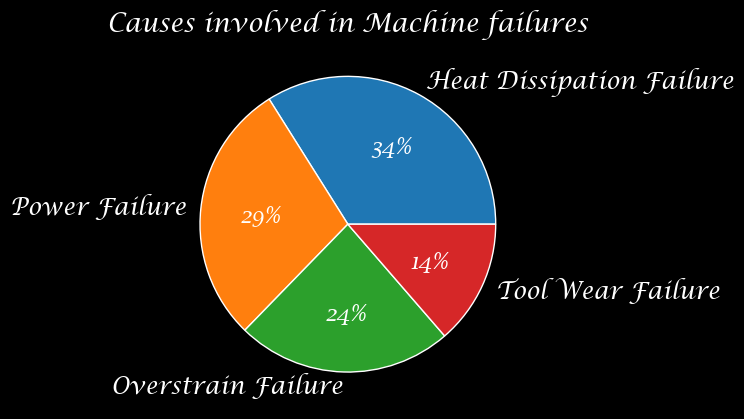

In [30]:
# Portion of df where there is a failure and causes percentage
idx_fail = df.loc[df['Failure Type'] != 'No Failure'].index
df_fail = df.loc[idx_fail]
df_fail_percentage = 100*df_fail['Failure Type'].value_counts()/df_fail['Failure Type'].shape[0]
print('Failures percentage in data:',
      round(100*df['Target'].sum()/n,2))
# Pie plot
plt.title('Causes involved in Machine failures')
plt.pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
plt.show()

When dealing with machine learning problems classes imbalance is a great concern, as it can
mislead both the models training process and our ability to interpret their results. As instance,
if we build a model on this dataset that predicts that machines never fail, it should be 97%
accurate. In order to avoid such effects and limit the preferential behaviour of the models with
respect to individual classes we perform a data augmentation, with the aim of obtaining a ratio
of 80 to 20 between functioning and faulty observations and the same percentage of occurrence
between the causes involved in the failures.

Among the most common data augmentation techniques we identify:
* Under-sampling by deleting some data points from the majority class.
* Over-Sampling by copying rows of data resulting in the minority class.
* Over-Sampling with SMOTE (Synthetic Minority Oversampling Technique).

The first two choices however result in extremely simplistic approaches; in particular the first one
has the disadvantage of decreasing the length of the dataset in a context in which the available
data are already limited. Therefore we use the SMOTE procedure to generate new samples,
which is very much like slightly moving the data point in the direction of its neighbors. This way,
the synthetic data point is not an exact copy of an existing data point but we can also be sure
that it is also not too different from the known observations in the minority class. To be more
precise, the SMOTE procedure works as follows: it draws a random sample from the minority class and for the observations in this sample, identifies the k nearest neighbors. It will then take
one of those neighbors and identify the vector between the current data point and the selected
neighbor. The vector will be multiplied by a random number between 0 and 1 and the synthetic
data point is obtained by adding this vector to the current data point.

In [31]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
# n_working must represent 80% of the desired length of resampled dataframe
n_working = df['Failure Type'].value_counts()['No Failure']
desired_length = round(n_working/0.8)
spc = round((desired_length-n_working)/4)  #samples per class
# Resampling
balance_cause = {'No Failure':n_working,
                 'Overstrain Failure':spc,
                 'Heat Dissipation Failure':spc,
                 'Power Failure':spc,
                 'Tool Wear Failure':spc}
sm = SMOTENC(categorical_features=[0,7], sampling_strategy=balance_cause, random_state=0)
df_res, y_res = sm.fit_resample(df, df['Failure Type'])

### 2.7) Comparison after resampling <a id="resample_comparison"></a>

The result is described in the following pie charts.

Percentage increment of observations after oversampling: 20.88
SMOTE Resampled Failures percentage: 20.01


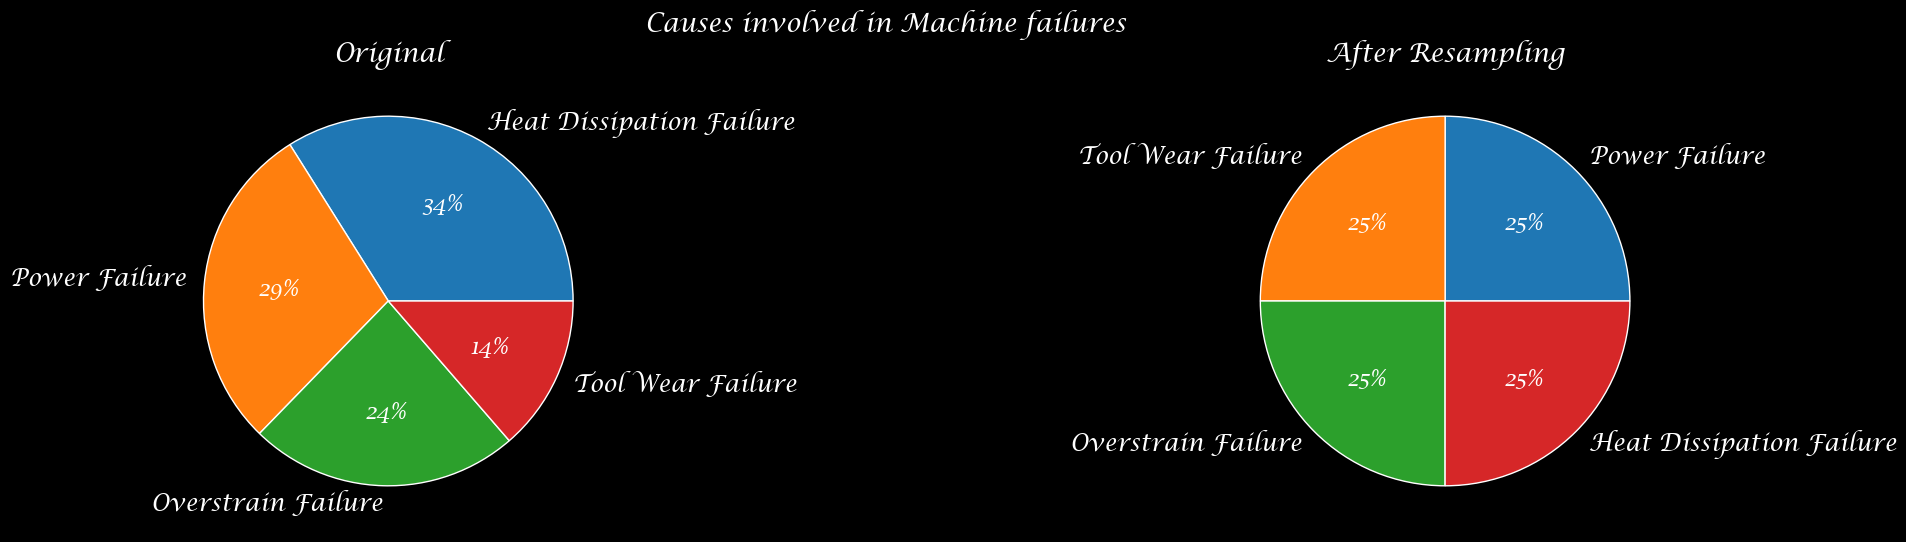

In [32]:
# Portion of df_res where there is a failure and causes percentage
idx_fail_res = df_res.loc[df_res['Failure Type'] != 'No Failure'].index
df_res_fail = df_res.loc[idx_fail_res]
fail_res_percentage = 100*df_res_fail['Failure Type'].value_counts()/df_res_fail.shape[0]

# Percentages
print('Percentage increment of observations after oversampling:',
      round((df_res.shape[0]-df.shape[0])*100/df.shape[0],2))
print('SMOTE Resampled Failures percentage:',
      round(df_res_fail.shape[0]*100/df_res.shape[0],2))

# Pie plot
fig, axs = plt.subplots(ncols=2, figsize=(25,6))
fig.suptitle('Causes involved in Machine failures')
axs[0].pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
axs[1].pie(x=fail_res_percentage.array, labels=fail_res_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
axs[0].title.set_text('Original')
axs[1].title.set_text('After Resampling')
plt.show()

As one can expect, the cases of Machine Failure mainly concern low quality machines, then
those of medium quality and only a few times those of high quality. This difference is accentuated
when the number of observations of non-functioning machines is (artificially) increased. However,
from the kdeplots below it can be seen that this is not widely correlated with the features since
differentiating according to the quality shows that distribution of the features does not present
big differences, except for the two side peaks in Tool Wear (which is consistent with the data
description). This suggests that probably the fact that the majority of failures concern type
L machines is due to the greater presence of this type in the dataset and therefore that the
correlation with the failure of the machine is due to statistical reasons.

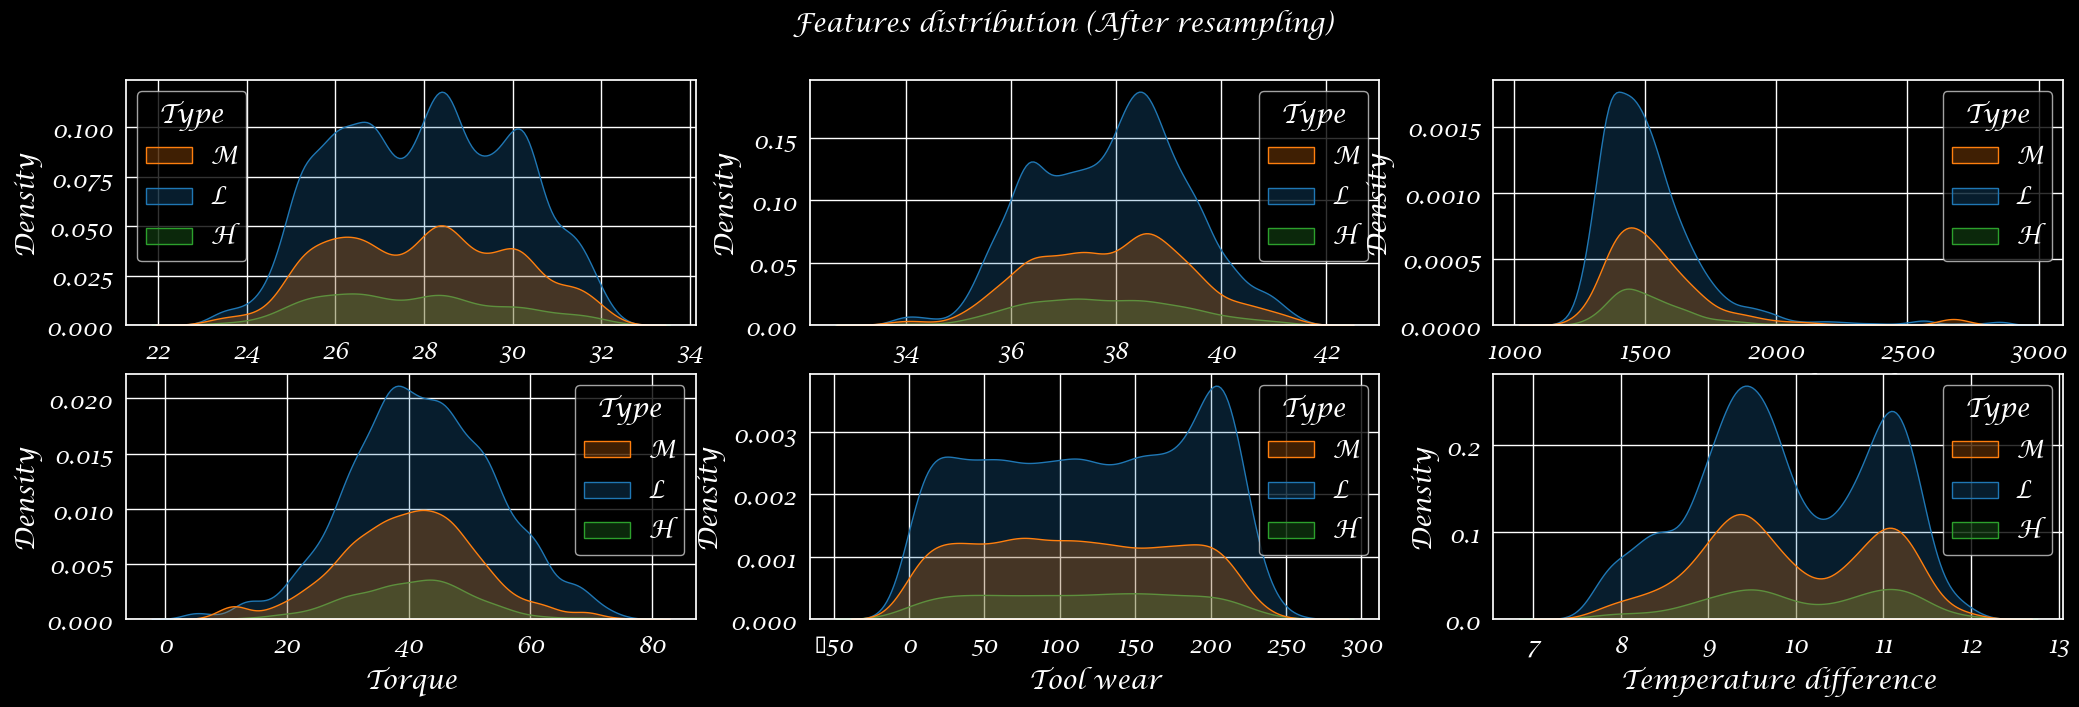

In [33]:
# Kdeplot of numeric features (After resampling) - hue=Type
num_features = [feature for feature in features if df[feature].dtype=='float64']
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25,7))
fig.suptitle('Features distribution (After resampling)')
custom_palette = {'L':'tab:blue', 'M':'tab:orange', 'H':'tab:green'}
for j, feature in enumerate(num_features):
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df_res, x=feature,
              hue='Type', fill=True, palette=custom_palette)
plt.show()

The first thing we can observe is that the data augmentation was performed succesfully, as the
feature distribution for faulty instancies have not been significantly distorted. It should also be
noted that in Rotational Speed, Torque and Tool Wear the observations relating to failures have
a density peak in extreme zones of the distribution. This implies that the outliers we discussed
in Section 2.3 are not to be imputed to mistakes in the dataset building but rather to the natural
variance of the same. This becomes even clearer when observing the distributions relative to the
single causes of failure: in particular, an almost symmetrical behavior is recognized in Rotational
Speed and Torque while in Tool Wear a clear separation is observed between PWF and HDF
failures on lower values, and the peaks that are found at higher values relative to TWF and OSF.
This is perfectly consistent with the description of the targets reported in the "Task and dataset
description" section.

### 2.8) Features scaling and Encoding <a id="encoding"></a>

In order to make data exploitable for the algorithms we will run, we apply two transformations:
* First, we apply a label encoding to the categorical columns, since Type is an ordinal feature
and Cause must be represented in one column. The mapping follows this scheme:
Type: {L=0, M=1, H=2}
Cause: {Working=0, PWF=1, OSF=2, HDF=3, TWF=4}
* Secondly we perform the scaling of the columns with StandardScaler. This is particularly
useful for the good working of methods that rely on the metric space, such as PCA and KNN.
It has been also verified that using StandardScaler leads to slightly better performances than
using MinMaxScaler.

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()
type_dict = {'L': 0, 'M': 1, 'H': 2}
cause_dict = {'No Failure': 0,
              'Power Failure': 1,
              'Overstrain Failure': 2,
              'Heat Dissipation Failure': 3,
              'Tool Wear Failure': 4}
df_pre = df_res.copy()
# Encoding
df_pre['Type'].replace(to_replace=type_dict, inplace=True)
df_pre['Failure Type'].replace(to_replace=cause_dict, inplace=True)
# Scaling
df_pre[num_features] = sc.fit_transform(df_pre[num_features]) 

### 2.9) PCA and Correlation Heatmap <a id="pca"></a>

We run PCA to have a further way of displaying the data instead of making feature selection.

In [35]:
pca = PCA(n_components=len(num_features))
X_pca = pd.DataFrame(data=pca.fit_transform(df_pre[num_features]), columns=['PC'+str(i+1) for i in range(len(num_features))])
var_exp = pd.Series(data=100*pca.explained_variance_ratio_, index=['PC'+str(i+1) for i in range(len(num_features))])
print('Explained variance ratio per component:', round(var_exp,2), sep='\n')
print('Explained variance ratio with 3 components: '+str(round(var_exp.values[:3].sum(),2)))

Explained variance ratio per component:
PC1    38.11
PC2    30.84
PC3    16.55
PC4    11.95
PC5     2.56
PC6     0.00
dtype: float64
Explained variance ratio with 3 components: 85.49


Since the first three components are enough to almost fully represent the variance of the data
we will project them in a three dimensional space.

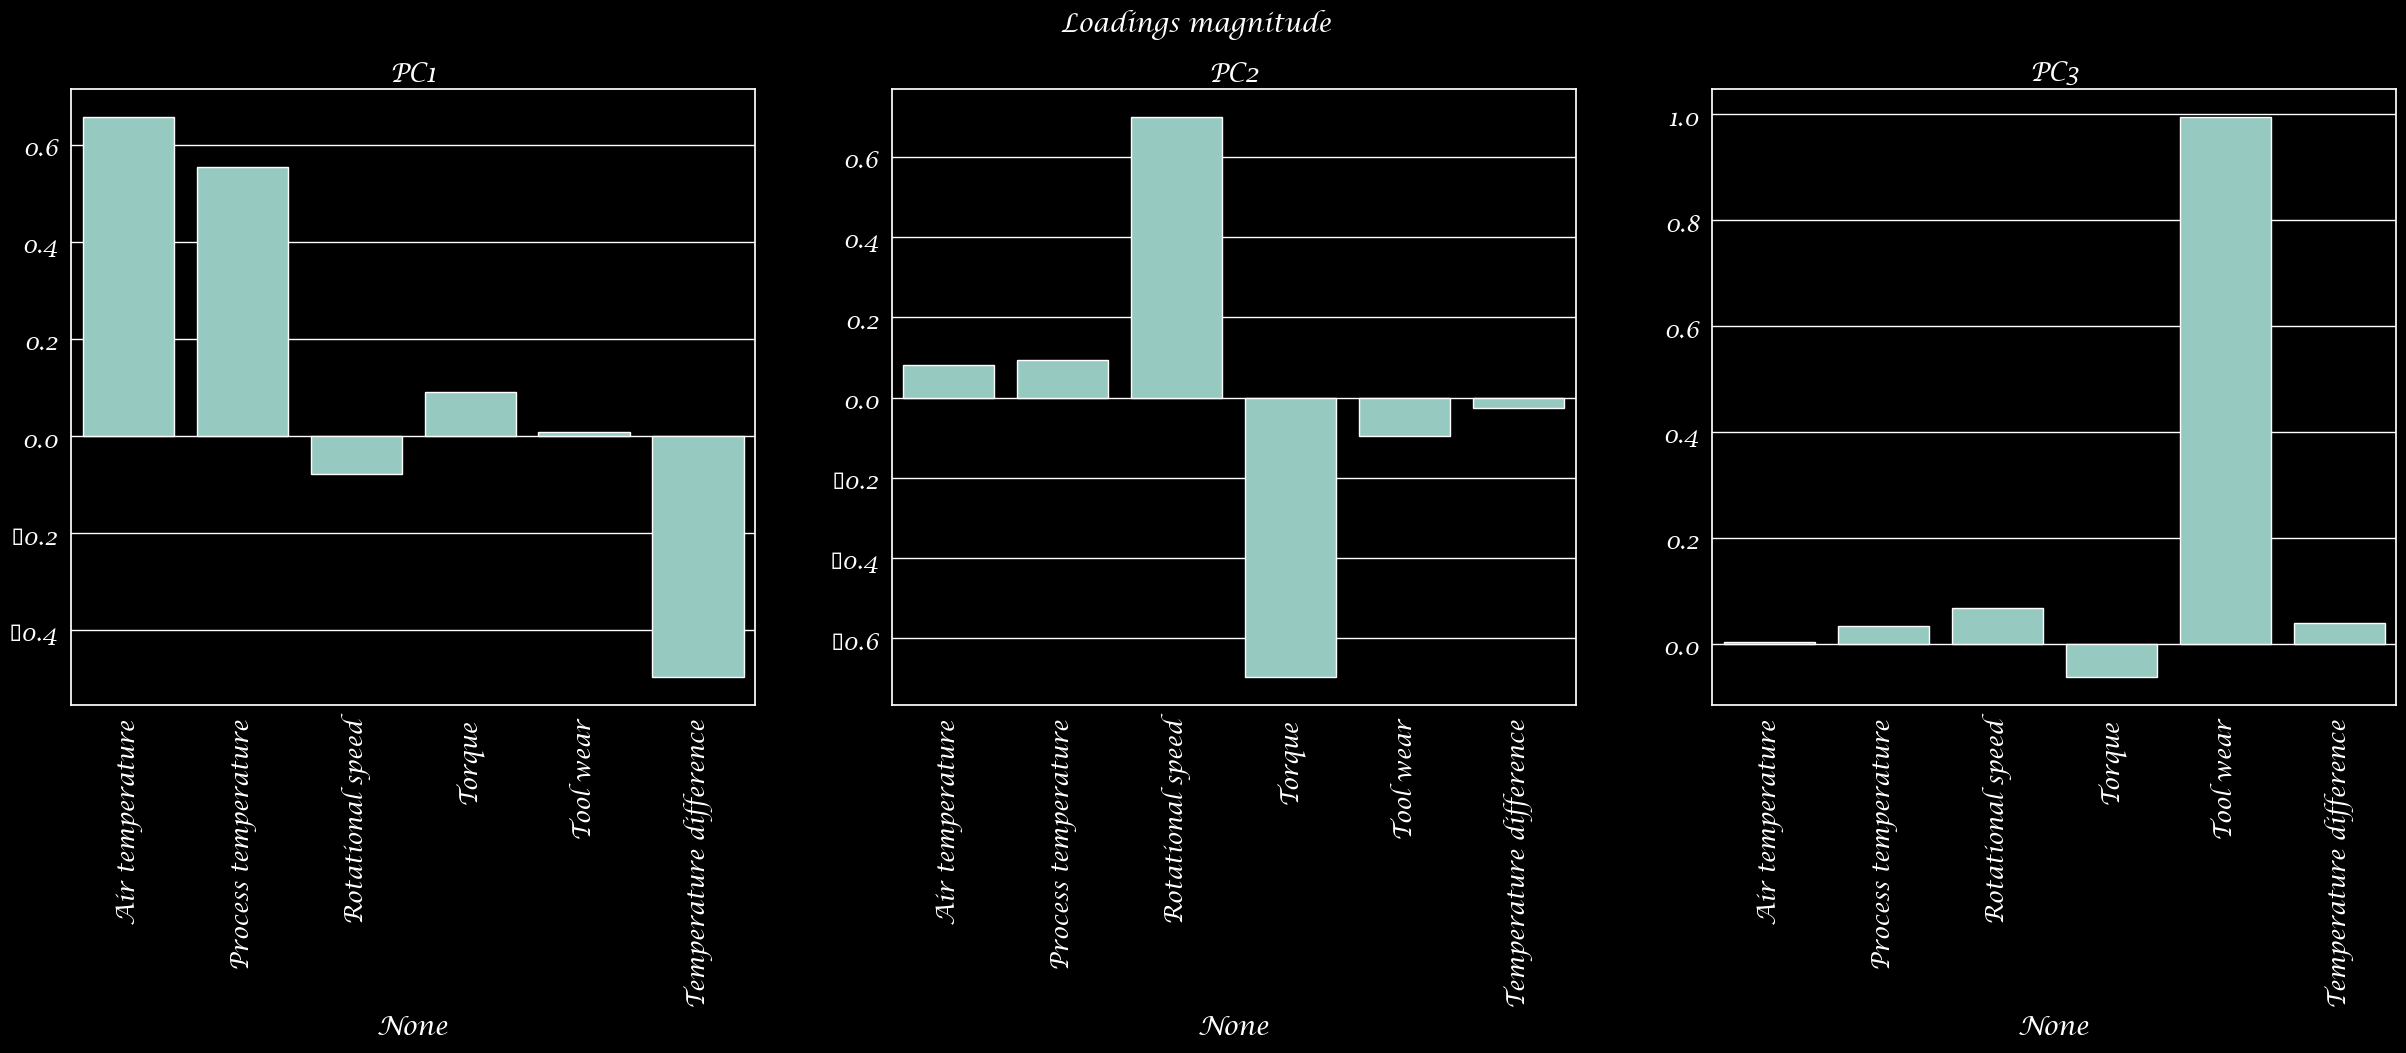

In [36]:
# PCA for Data visualization
pca3 = PCA(n_components=3)
X_pca3 = pd.DataFrame(data=pca3.fit_transform(df_pre[num_features]), columns=['PC1','PC2','PC3'])

# Loadings Analysis
fig, axs = plt.subplots(ncols=3, figsize=(30,8))
fig.suptitle('Loadings magnitude')
pca_loadings = pd.DataFrame(data=pca3.components_, columns=num_features)
for j in range(3):
    ax = axs[j]
    sns.barplot(ax=ax, x=pca_loadings.columns, y=pca_loadings.values[j])
    ax.tick_params(axis='x', rotation=90)
    ax.title.set_text('PC'+str(j+1))
plt.show()  

The bar plot of Principal Components weights makes easy to understand what they represent:
* PC1 is closely related to the two temperature data;
* PC2 can be identified with the machine power, which is the product of Rotational Speed
and Torque;
* PC3 is identifiable with Tool Wear.

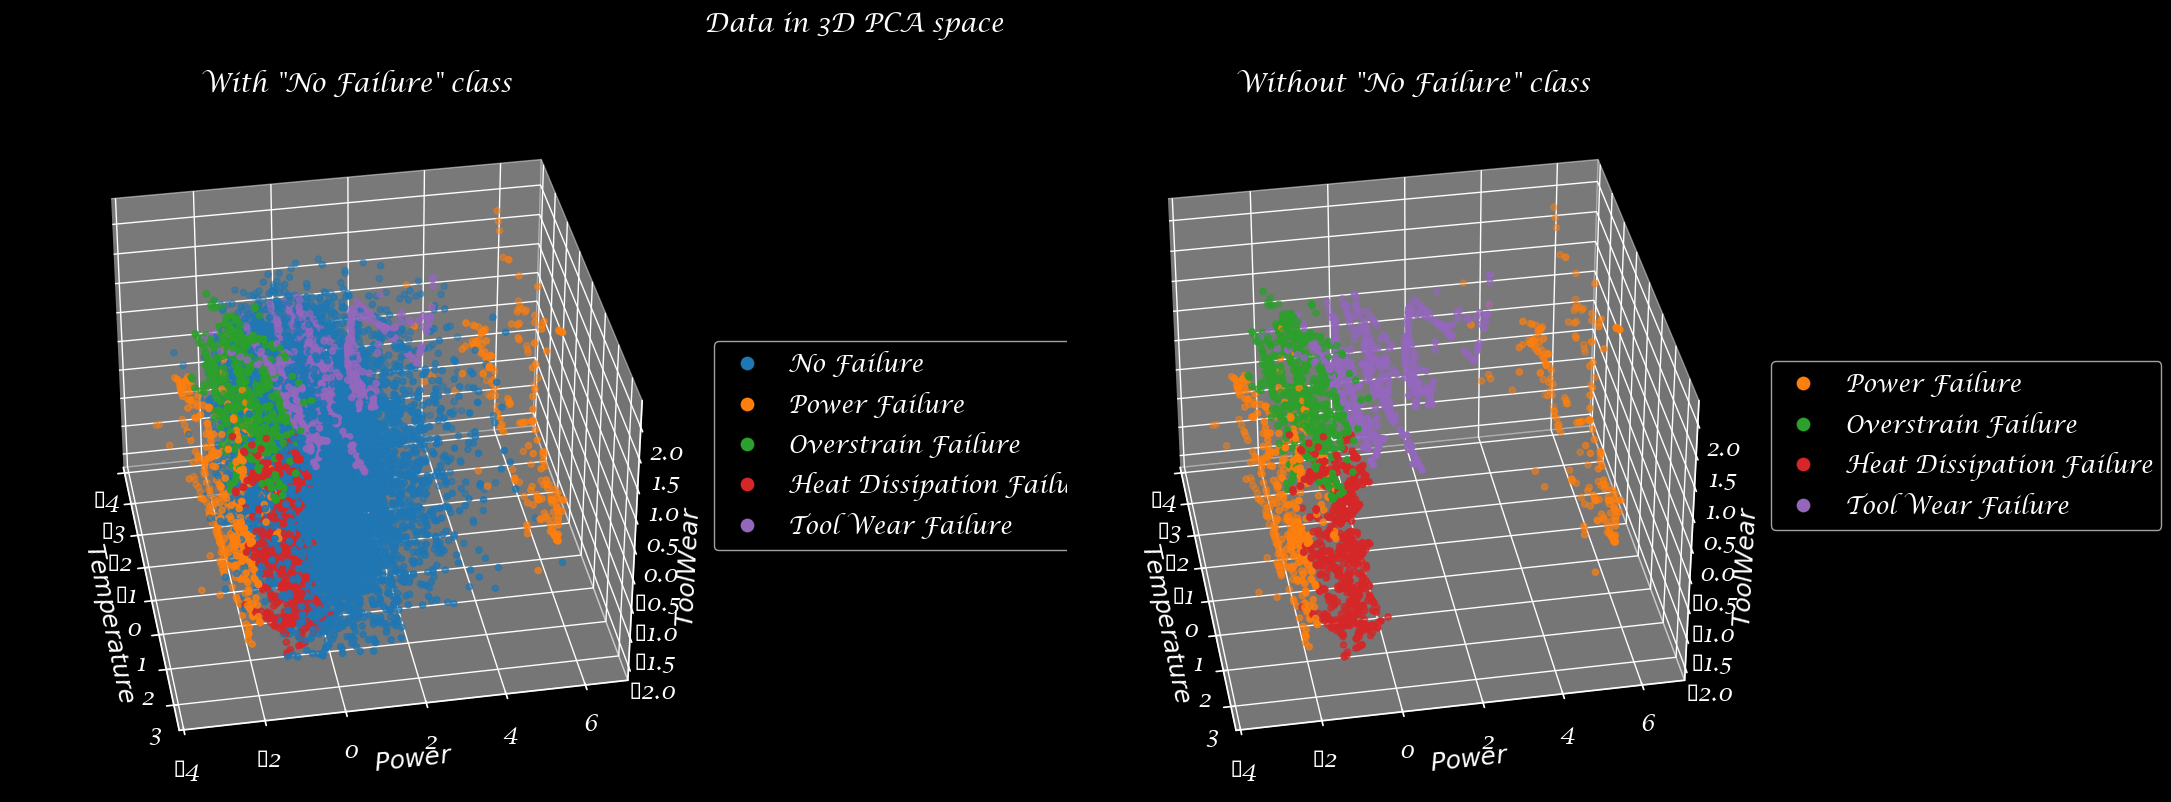

In [37]:
X_pca3.rename(mapper={'PC1':'Temperature',
                      'PC2':'Power',
                      'PC3':'Tool Wear'}, axis=1, inplace=True)

# PCA plot
color = []
col = df_pre['Failure Type'].map({0:'tab:blue',1:'tab:orange',2:'tab:green',3:'tab:red',4:'tab:purple'})
color.append(col)
idx_w = col[col == 'tab:blue'].index
color.append(col.drop(idx_w))
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
labelTups = [('No Failure','tab:blue'),
             ('Power Failure', 'tab:orange'),
             ('Overstrain Failure','tab:green'),
             ('Heat Dissipation Failure', 'tab:red'),
             ('Tool Wear Failure','tab:purple')]

fig = plt.figure(figsize=(25,9))
fig.suptitle('Data in 3D PCA space')
full_idx = X_pca3.index

for j, idx in enumerate([full_idx,idx_fail_res]):
    ax = fig.add_subplot(1, 2, j+1, projection='3d')

    lg = ax.scatter(X_pca3.loc[idx,'Temperature'],
                    X_pca3.loc[idx,'Power'],
                    X_pca3.loc[idx,'Tool Wear'],
                    c=color[j])
    ax.set_xlabel('$Temperature$')
    ax.set_ylabel('$Power$')
    ax.set_zlabel('$Tool Wear$')
    ax.title.set_text('With'+str(j*'out')+' "No Failure" class')
    ax.view_init(35, -10) 
    custom_lines = [plt.Line2D([],[], ls="", marker='.', 
                               mec='k', mfc=c, mew=.1, ms=20) for c in colors[j:]]
    ax.legend(custom_lines, [lt[0] for lt in labelTups[j:]], 
              loc='center left', bbox_to_anchor=(1.0, .5))
      
plt.show()

The projection into the space generated by these three axes highlights that:
* TWF is the class of failures best separated from all the others and seems to depend almost
entirely on PC3 (Tool Wear);
* PWF occupies two extreme bands along the PC2 (Power), it is independent of the other
two components;
18
* The OSF and HDF classes are less separated than the others even if it can be observed
that the first is characterized by a high Tool Wear and low power while the second is
characterized by a high temperature and a low power.

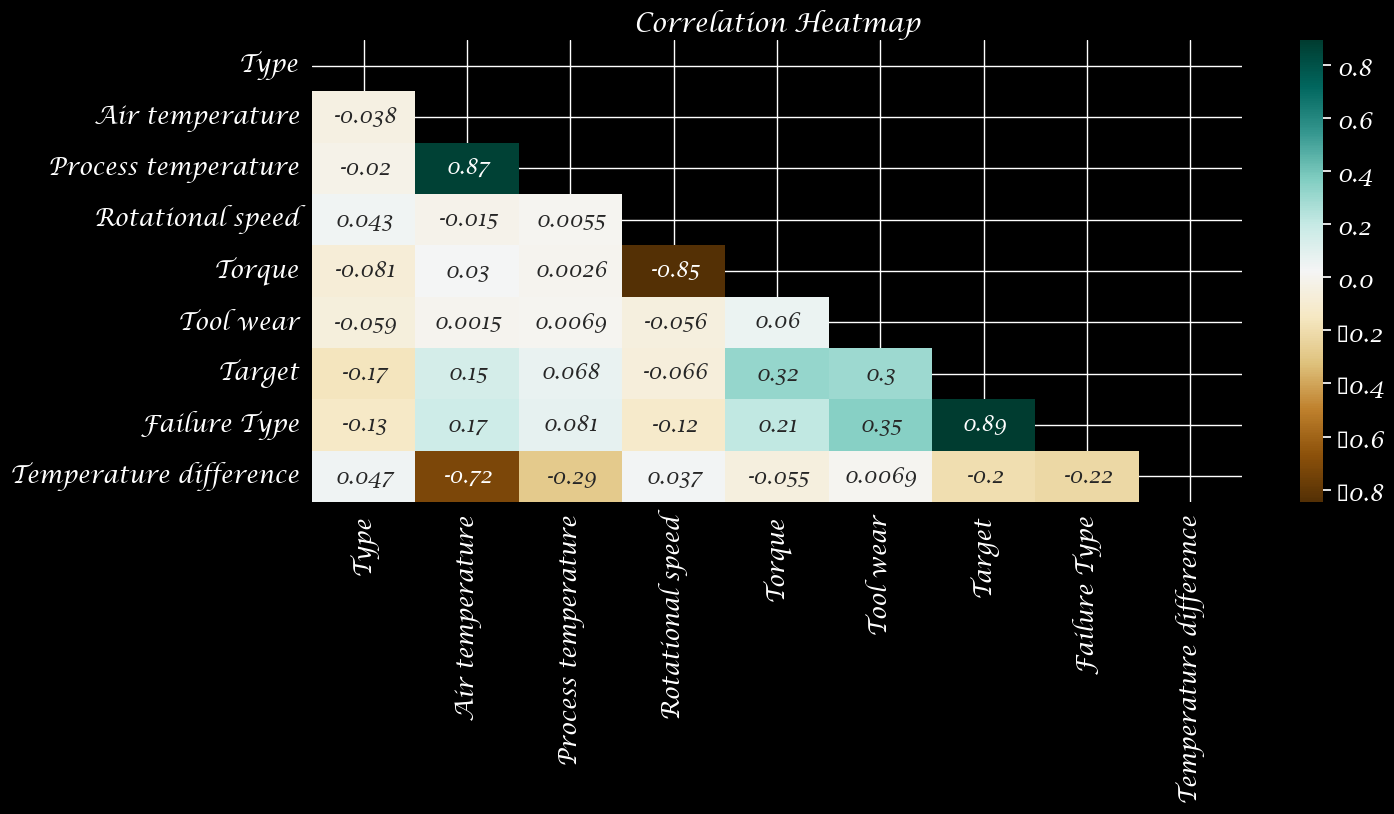

In [38]:
# Correlation Heatmap
plt.figure(figsize=(15,6))
sns.heatmap(data=df_pre.corr(), mask=np.triu(df_pre.corr()), annot=True, cmap='BrBG')
plt.title('Correlation Heatmap')
plt.show()

Unsurprisingly, we observe that the features related to temperature, as well as those related to
power, are widely correlated. Furthermore, Tool Wear correlates well with both of our targets,
confirming what we have observed by studying PCA. Finally, a less strong correlation is also
observed between the torsion and the two targets.

## 3) **Training Models** <a id="models"></a> 

### 3.1) Feature Selection <a id="feature"></a>

In [39]:
import category_encoders as ce
encoder = ce.OrdinalEncoder(cols=['Type','Failure Type'])
df = encoder.fit_transform(df)
df.head(2)

Type  Air temperature  Process temperature  Rotational speed  Torque  \
0     1            25.95                36.45            1551.0    42.8   
1     2            26.05                36.55            1408.0    46.3   

   Tool wear  Target  Failure Type  Temperature difference  
0        0.0       0             1                    10.5  
1        3.0       0             1                    10.5

### 3.2) Label Encoding <a id="label"></a>

In [40]:
from sklearn.preprocessing import LabelEncoder
scaler = LabelEncoder()
df['Failure Type'] = scaler.fit_transform(df['Failure Type'])

### 3.3) Training Dataset <a id="training_dataset"></a>

In [41]:
X = df.drop(columns="Failure Type" , axis=1)
y = df["Failure Type"]

In [42]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=21)

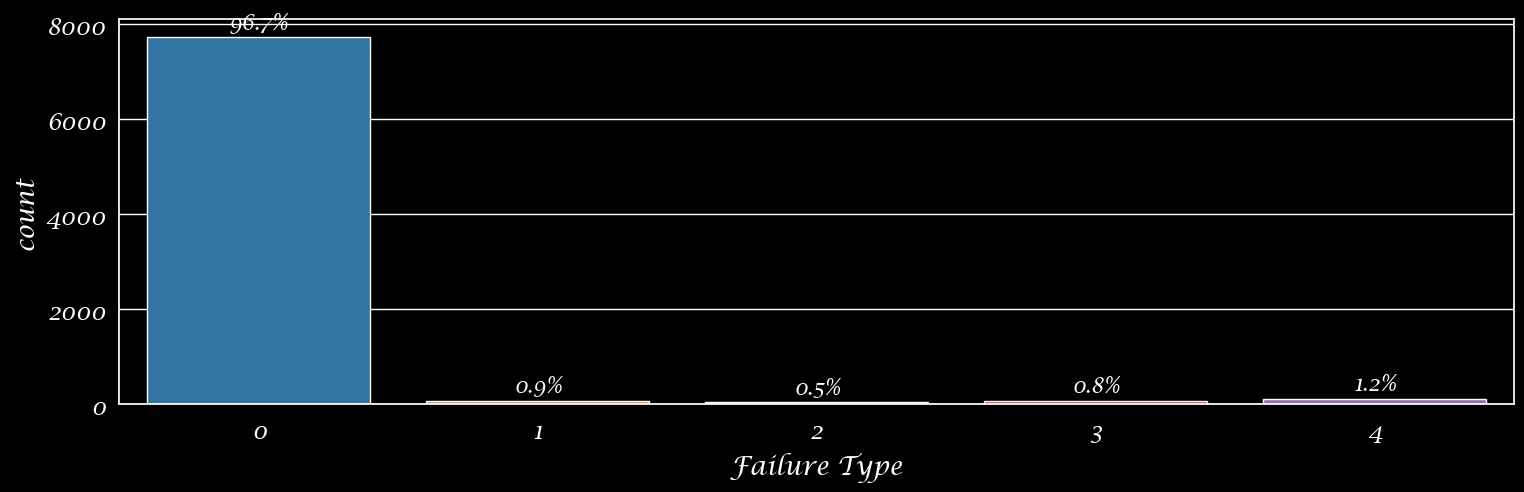

In [43]:
plt.figure(figsize=(18,5))
ax = sns.countplot(x = y_train, palette = 'tab10')
t= len(y_train)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / t:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.show()

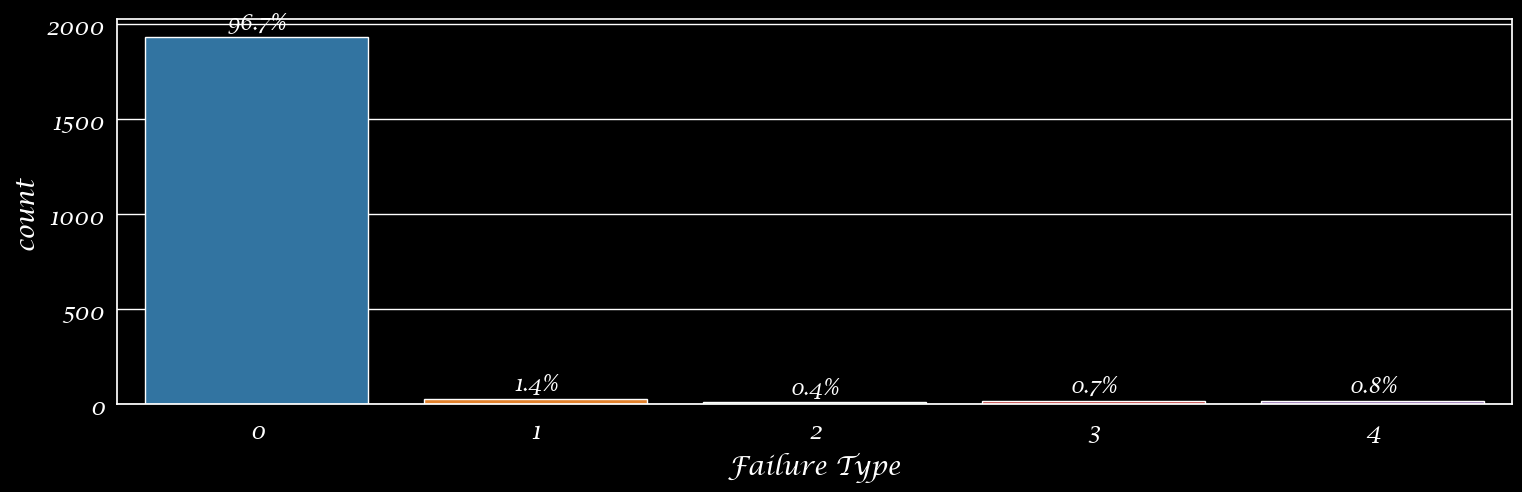

In [44]:
plt.figure(figsize=(18,5))
ax = sns.countplot(x = y_test, palette = 'tab10')
t= len(y_test)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / t:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.show()

## 4) **Model Evaluation** <a id="evaluation"></a> 

<span class="label label-default" style="background-color:#0000FF; border-radius:0px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">LogisticRegression 📊📈</span>

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit the model and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate accuracies
    train_acc = round(model.score(X_train, y_train) * 100, 2)
    test_acc = round(accuracy_score(y_test, y_pred) * 100, 2)
    
    # Capture results
    results = {
        'Model': model.__class__.__name__,
        'Training Accuracy (%)': train_acc,
        'Test Accuracy (%)': test_acc
    }
    
    # Create DataFrame for better visualization
    results_df = pd.DataFrame([results])
    
    # Display the results with styling
    styled_results = results_df.style.format(precision=2).set_properties(
        **{
            'background-color': '#00CFFF',
            'color': 'black',
            'border-color': 'black',
            'font-weight': 'bold',
            'text-align': 'center'
        }
    )
    
    # Display the styled DataFrame
    display(styled_results)
    
    # Display the Classification Report
    print("\033[1m--------------------------------------------------------\033[0m")
    print(f"Classification Report for {model.__class__.__name__}:\n", classification_report(y_test, y_pred))
    print("\033[1m--------------------------------------------------------\033[0m")
    
    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.show()
    
    return train_acc, test_acc

# Sample models for testing
models_data = []



--------------------------------------------------------
Classification Report for GridSearchCV:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1930
           1       1.00      0.85      0.92        27
           2       1.00      0.75      0.86         8
           3       0.75      0.86      0.80        14
           4       0.80      1.00      0.89        16

    accuracy                           1.00      1995
   macro avg       0.91      0.89      0.89      1995
weighted avg       1.00      1.00      1.00      1995

--------------------------------------------------------


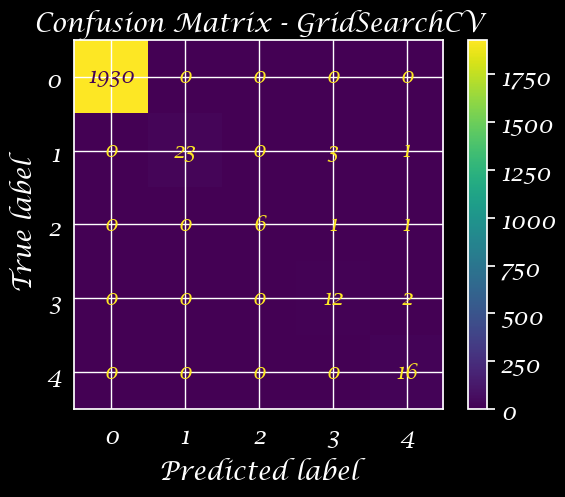

In [46]:
# Logistic Regression
grid_lr = GridSearchCV(LogisticRegression(), 
                       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'saga']}, 
                       cv=5, scoring='accuracy', n_jobs=-1)
train_acc, test_acc = evaluate_model(grid_lr, X_train, y_train, X_test, y_test)
models_data.append(["Logistic Regression", train_acc, test_acc])


<span class="label label-default" style="background-color:#0000FF; border-radius:0px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">Decision Tree Classifier 🎄</span>

--------------------------------------------------------
Classification Report for GridSearchCV:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1930
           1       0.88      0.85      0.87        27
           2       0.80      1.00      0.89         8
           3       0.79      0.79      0.79        14
           4       1.00      0.94      0.97        16

    accuracy                           1.00      1995
   macro avg       0.89      0.92      0.90      1995
weighted avg       1.00      1.00      1.00      1995

--------------------------------------------------------


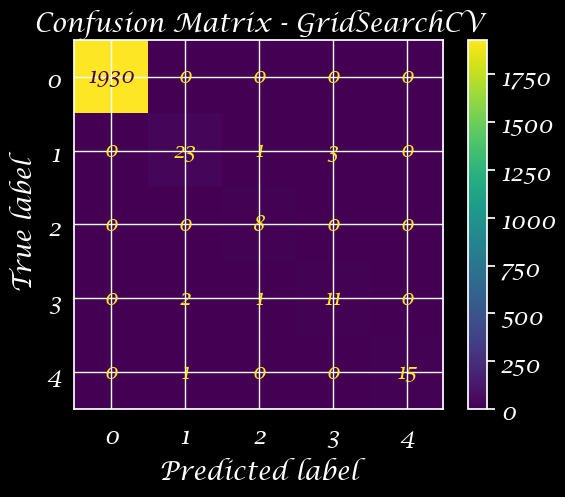

In [47]:
# Decision Tree
grid_dt = GridSearchCV(DecisionTreeClassifier(), 
                        param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 20]},
                        cv=5, scoring='accuracy', n_jobs=-1)
train_acc, test_acc = evaluate_model(grid_dt, X_train, y_train, X_test, y_test)
models_data.append(["Decision Tree", train_acc, test_acc])


<span class="label label-default" style="background-color:#0000FF; border-radius:0px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">Random Forest Classifier 🎄🎄🎄</span>

--------------------------------------------------------
Classification Report for GridSearchCV:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1930
           1       1.00      0.78      0.88        27
           2       1.00      1.00      1.00         8
           3       0.76      0.93      0.84        14
           4       0.84      1.00      0.91        16

    accuracy                           1.00      1995
   macro avg       0.92      0.94      0.93      1995
weighted avg       1.00      1.00      1.00      1995

--------------------------------------------------------


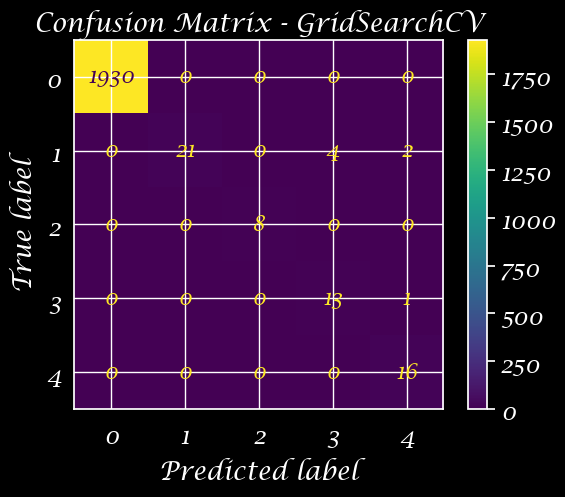

In [48]:

# Random Forest
grid_rf = GridSearchCV(RandomForestClassifier(), 
                        param_grid={'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20]},
                        cv=5, scoring='accuracy', n_jobs=-1)
train_acc, test_acc = evaluate_model(grid_rf, X_train, y_train, X_test, y_test)
models_data.append(["Random Forest", train_acc, test_acc])


<span class="label label-default" style="background-color:#0000FF; border-radius:0px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">SVM 📚</span>

--------------------------------------------------------
Classification Report for GridSearchCV:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1930
           1       0.96      0.96      0.96        27
           2       0.89      1.00      0.94         8
           3       0.86      0.86      0.86        14
           4       1.00      0.94      0.97        16

    accuracy                           1.00      1995
   macro avg       0.94      0.95      0.95      1995
weighted avg       1.00      1.00      1.00      1995

--------------------------------------------------------


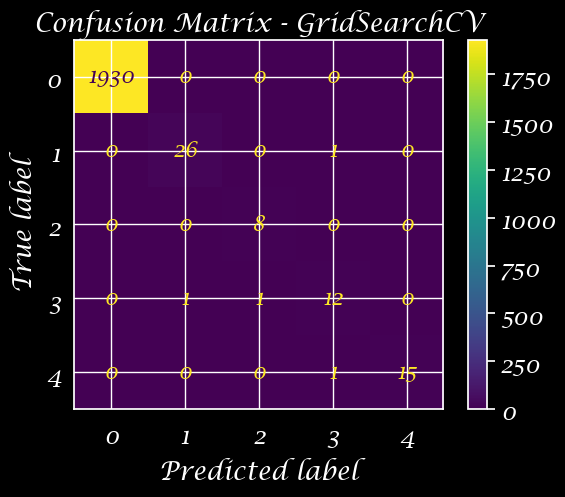

In [49]:

# Support Vector Machines
grid_svc = GridSearchCV(SVC(), 
                         param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
                         cv=5, scoring='accuracy', n_jobs=-1)
train_acc, test_acc = evaluate_model(grid_svc, X_train, y_train, X_test, y_test)
models_data.append(["Support Vector Machines", train_acc, test_acc])



<span class="label label-default" style="background-color:#0000FF; border-radius:0px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">K-Nearest Neighbours 📊</span>

--------------------------------------------------------
Classification Report for GridSearchCV:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1930
           1       0.80      0.30      0.43        27
           2       0.00      0.00      0.00         8
           3       0.47      0.50      0.48        14
           4       0.50      0.06      0.11        16

    accuracy                           0.97      1995
   macro avg       0.55      0.37      0.40      1995
weighted avg       0.96      0.97      0.97      1995

--------------------------------------------------------


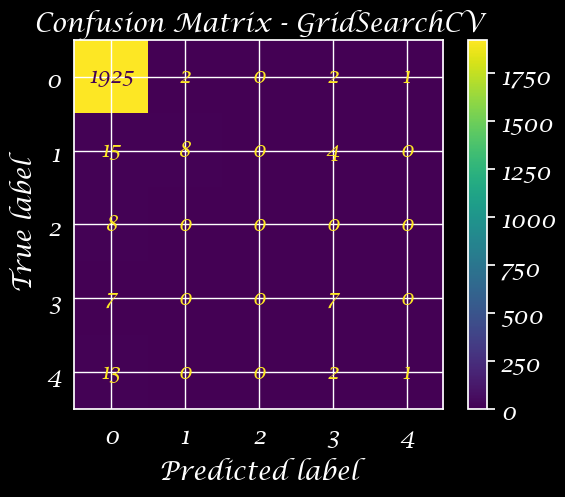

In [50]:
# k-Nearest Neighbors
grid_knn = GridSearchCV(KNeighborsClassifier(), 
                         param_grid={'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']},
                         cv=5, scoring='accuracy', n_jobs=-1)
train_acc, test_acc = evaluate_model(grid_knn, X_train, y_train, X_test, y_test)
models_data.append(["k-Nearest Neighbors", train_acc, test_acc])


<span class="label label-default" style="background-color:#0000FF; border-radius:0px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">Naïve Bayes 📈</span>

--------------------------------------------------------
Classification Report for GaussianNB:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1930
           1       1.00      0.67      0.80        27
           2       0.89      1.00      0.94         8
           3       0.73      0.79      0.76        14
           4       0.70      1.00      0.82        16

    accuracy                           0.99      1995
   macro avg       0.86      0.89      0.86      1995
weighted avg       1.00      0.99      0.99      1995

--------------------------------------------------------


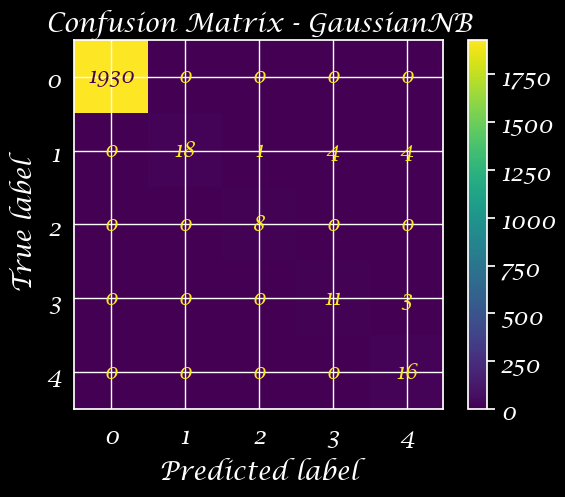

In [51]:

# Naïve Bayes
gnb = GaussianNB()
train_acc, test_acc = evaluate_model(gnb, X_train, y_train, X_test, y_test)
models_data.append(["Naïve Bayes", train_acc, test_acc])


<span class="label label-default" style="background-color:#0000FF; border-radius:0px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">Gradient Boosting 📈</span>

--------------------------------------------------------
Classification Report for GridSearchCV:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1930
           1       1.00      0.81      0.90        27
           2       1.00      1.00      1.00         8
           3       0.70      1.00      0.82        14
           4       1.00      0.94      0.97        16

    accuracy                           1.00      1995
   macro avg       0.94      0.95      0.94      1995
weighted avg       1.00      1.00      1.00      1995

--------------------------------------------------------


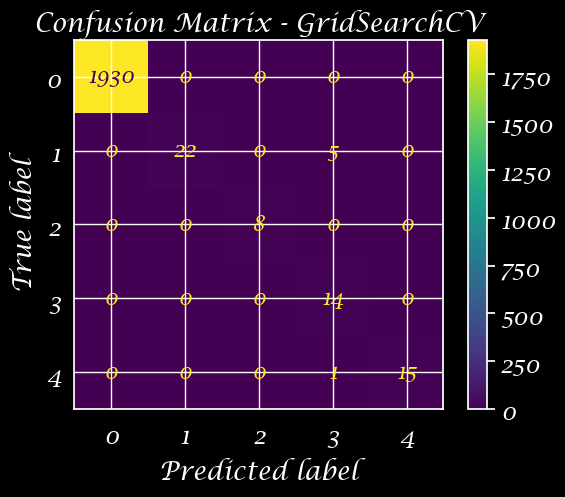

In [52]:

# Gradient Boosting
grid_gb = GridSearchCV(GradientBoostingClassifier(), 
                        param_grid={'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
                        cv=5, scoring='accuracy', n_jobs=-1)
train_acc, test_acc = evaluate_model(grid_gb, X_train, y_train, X_test, y_test)
models_data.append(["Gradient Boosting", train_acc, test_acc])


<span class="label label-default" style="background-color:#0000FF; border-radius:0px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">AdaBoost 📊</span>

--------------------------------------------------------
Classification Report for GridSearchCV:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1930
           1       1.00      0.70      0.83        27
           2       1.00      0.88      0.93         8
           3       0.72      0.93      0.81        14
           4       0.76      1.00      0.86        16

    accuracy                           0.99      1995
   macro avg       0.90      0.90      0.89      1995
weighted avg       1.00      0.99      0.99      1995

--------------------------------------------------------


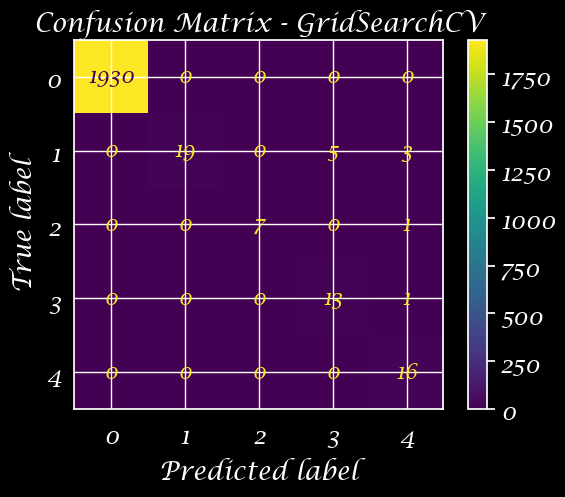

In [53]:

# AdaBoost
grid_ab = GridSearchCV(AdaBoostClassifier(), 
                        param_grid={'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]},
                        cv=5, scoring='accuracy', n_jobs=-1)
train_acc, test_acc = evaluate_model(grid_ab, X_train, y_train, X_test, y_test)
models_data.append(["AdaBoost", train_acc, test_acc])


<span class="label label-default" style="background-color:#0000FF; border-radius:0px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">Extra Trees 📈</span>

--------------------------------------------------------
Classification Report for GridSearchCV:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1930
           1       1.00      0.74      0.85        27
           2       1.00      1.00      1.00         8
           3       0.73      0.79      0.76        14
           4       0.73      1.00      0.84        16

    accuracy                           0.99      1995
   macro avg       0.89      0.91      0.89      1995
weighted avg       1.00      0.99      1.00      1995

--------------------------------------------------------


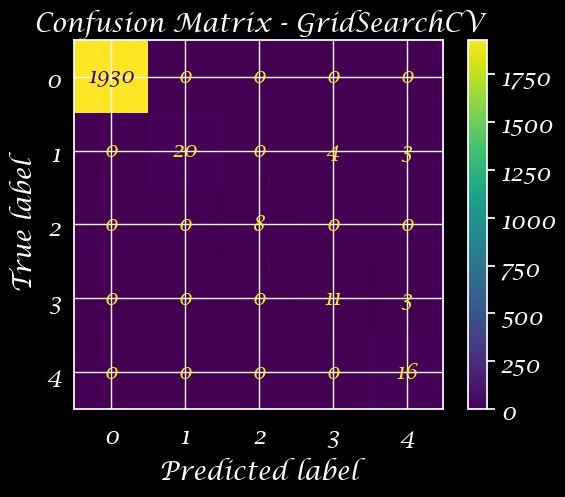

In [54]:

# Extra Trees
grid_et = GridSearchCV(ExtraTreesClassifier(), 
                        param_grid={'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20]},
                        cv=5, scoring='accuracy', n_jobs=-1)
train_acc, test_acc = evaluate_model(grid_et, X_train, y_train, X_test, y_test)
models_data.append(["Extra Trees", train_acc, test_acc])


<span class="label label-default" style="background-color:#0000FF; border-radius:0px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">Model Buiding 📚</span>

In [55]:
# Create the DataFrame
models = pd.DataFrame(models_data, columns=["Model", "Training Accuracy", "Model Accuracy Score"])

# Function to highlight the entire row of the best-performing model
def highlight_best_row(row):
    is_best = row["Model Accuracy Score"] == models["Model Accuracy Score"].max()
    return ['background-color: blue' if is_best else '' for _ in row]

# Style the DataFrame with the best model row highlighted
styled_models = models.style.format({
    "Training Accuracy": "{:.2f} %",
    "Model Accuracy Score": "{:.2f} %"
}).set_properties(
    **{
        'background-color': '#4CAF50',  # Background color for all rows
        'color': 'white',  # Text color
        'border-color': 'black',  # Border color
        'text-align': 'center',  # Align text to the center
        'font-weight': 'bold'  # Make the text bold
    }
).apply(highlight_best_row, axis=1)  
styled_models = styled_models.hide(axis='index')

# Display the styled DataFrame
display(styled_models)

<span class="label label-default" style="background-color:#0000FF; border-radius:0px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">Result 📚</span>

In [58]:
prediction1 = grid_svc.predict(X_test)
print(prediction1)

[0 0 0 ... 0 0 0]


In [60]:
cross_checking = pd.DataFrame({'Actual' : y_test , 'Predicted' : prediction1})
cross_checking.sample(10).style.background_gradient(
        cmap='coolwarm').set_properties(**{
            'font-family': 'Lucida Calligraphy',
            'color': 'LigntGreen',
            'font-size': '15px'
        })

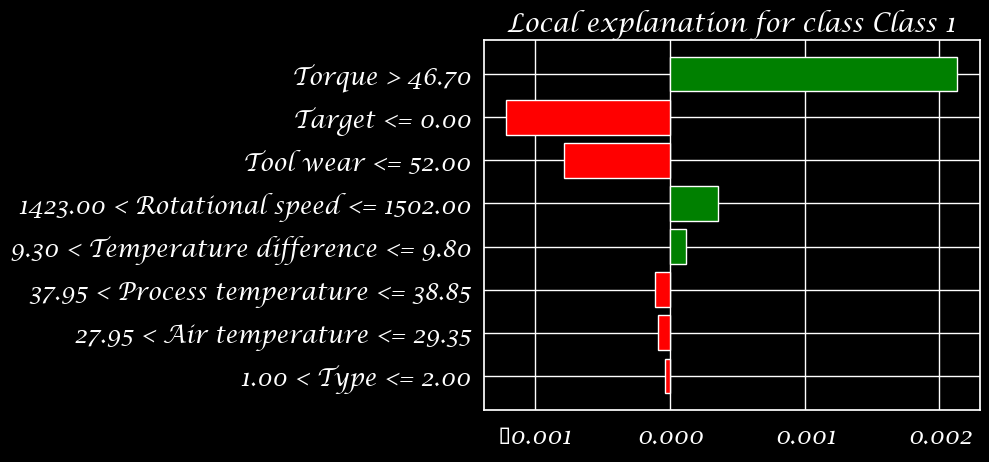

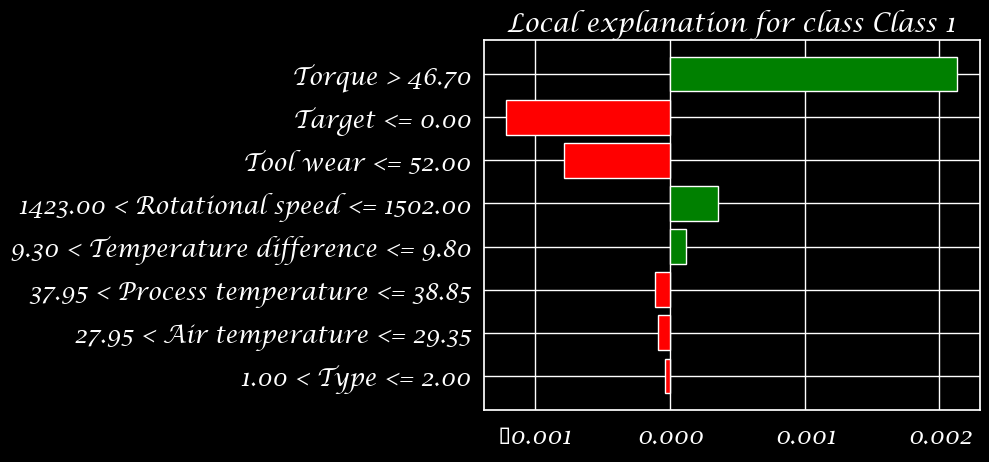

In [61]:
from sklearn.svm import SVC

# Create the SVC model with probability estimation enabled
svc = SVC(probability=True, random_state=42)

# Train the model (make sure you have already split your data into training and test sets)
svc.fit(X_train, y_train)

# Now, you can use 'predict_proba' for LIME
from lime.lime_tabular import LimeTabularExplainer

# Create a LimeTabularExplainer object
explainer = LimeTabularExplainer(
    training_data=X_train.values,  # Your training data
    training_labels=y_train,  # Your training labels
    mode='classification',  # This is a classification problem
    feature_names=X_train.columns,  # Feature names (assuming X_train is a DataFrame)
    class_names=['Class 0', 'Class 1'],  # Adjust this based on your class labels
    discretize_continuous=True  # Optionally discretize continuous features
)

# Choose a random instance from the test set to explain
i = 0  # For example, you can choose the first test instance
test_instance = X_test.iloc[i].values.reshape(1, -1)  # Reshaping the test instance to match the expected shape

# Explain the prediction for this instance
explanation = explainer.explain_instance(test_instance[0], svc.predict_proba)  # Using 'predict_proba' for probabilities

# Show the explanation in a notebook (for Jupyter Notebook)
explanation.show_in_notebook()

# You can also get a visual explanation for the instance
explanation.as_pyplot_figure()
